In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading meme data

In [2]:
data = pd.read_csv('../data/processed/gaming.csv')

print(data.shape)
data.head()

(125654, 10)


timestamp      open      high       low     close        volume    name  \
0  1639526400  4.744375  5.317031  2.173027  3.078208  1.480910e+06  SENATE   
1  1639612800  3.090095  3.299374  2.405868  2.605501  6.657927e+05  SENATE   
2  1639699200  2.625207  3.096436  2.283871  2.741340  5.401045e+05  SENATE   
3  1639785600  2.771380  3.038297  2.604262  2.720898  2.294669e+05  SENATE   
4  1639872000  2.726673  2.815944  2.498097  2.724654  1.654344e+05  SENATE   

   symbol                                    id category  
0  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
1  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
2  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
3  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
4  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125654 entries, 0 to 125653
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  125654 non-null  int64  
 1   open       125654 non-null  float64
 2   high       125654 non-null  float64
 3   low        125654 non-null  float64
 4   close      125654 non-null  float64
 5   volume     125654 non-null  float64
 6   name       125654 non-null  object 
 7   symbol     125654 non-null  object 
 8   id         125654 non-null  object 
 9   category   125654 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 9.6+ MB


## Preprocessing data

In [4]:
data_cleaned = u.removing_duplicates(data)

### Capping time series

Capping the first timestamp of each token with the most common one in order to avoid error when predicting.

In [5]:
data_capped = u.capping_time_series(data_cleaned)

In [6]:
# check how many tokens left
tokens = data_cleaned.groupby('id')['name'].value_counts()
tokens.describe()

count     103.000000
mean     1045.097087
std       560.569677
min       100.000000
25%       813.500000
50%      1078.000000
75%      1252.000000
max      3022.000000
Name: count, dtype: float64

In [7]:
data_datetime = u.timestamp_to_datetime(data_capped)

In [8]:
# reset the index
data_datetime.reset_index(drop=True, inplace=True)
data_datetime.head()

timestamp      open      high       low     close        volume  name  \
0 2021-07-14  0.011649  0.011649  0.011647  0.011647     70.185122  Mist   
1 2021-07-21  0.062068  0.062071  0.062068  0.062071    707.952893  Mist   
2 2021-07-22  0.080175  0.088427  0.080175  0.086998   8351.780213  Mist   
3 2021-07-23  0.097680  0.107641  0.097680  0.105690  16235.237605  Mist   
4 2021-07-24  0.120923  0.206081  0.120923  0.205990  69534.522595  Mist   

  symbol                                    id category  
0   MIST  06963e10-2042-41d3-9583-acb4135460dc   gaming  
1   MIST  06963e10-2042-41d3-9583-acb4135460dc   gaming  
2   MIST  06963e10-2042-41d3-9583-acb4135460dc   gaming  
3   MIST  06963e10-2042-41d3-9583-acb4135460dc   gaming  
4   MIST  06963e10-2042-41d3-9583-acb4135460dc   gaming

### Scaling

In [9]:
data_final, series_scaler, exog_scaler = u.scaling(data_datetime)

In [10]:
train_data, test_data = u.train_test_split(data_final)

In [11]:
# SHOW NUMBER UNIQUE TOKENS
train_data['id'].nunique()

60

In [12]:
# plot_time_series(meme, 20)

In [13]:
days_to_predict = 7

In [14]:
series, exog = u.create_series_exog(train_data)
future_exog = u.create_all_future_exog(train_data, exog_scaler=exog_scaler,days=days_to_predict)

In [15]:
series_dict, exog_dict, future_exog_dict = u.create_dictionaries(series, exog, future_exog)

In [16]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# num_tokens = len(series_dict)

# if len(colors) < num_tokens:
#     colors = colors * (len(series_dict) // len(colors) + 1)
# fig, axs = plt.subplots(num_tokens, 1, figsize=(20, num_tokens), sharex=True)
# for i, s in enumerate(series_dict.values()):
#     axs[i].plot(s, label=s.name, color=colors[i])
#     axs[i].legend(loc='upper right', fontsize=8)
#     axs[i].tick_params(axis='both', labelsize=8)

In [17]:
forecaster = u.train_forecaster(series_dict, exog_dict)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2865
[LightGBM] [Info] Number of data points in the train set: 80319, number of used features: 12
[LightGBM] [Info] Start training from score 0.000875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [18]:
predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=forecaster, future_exog_dict=future_exog_dict)

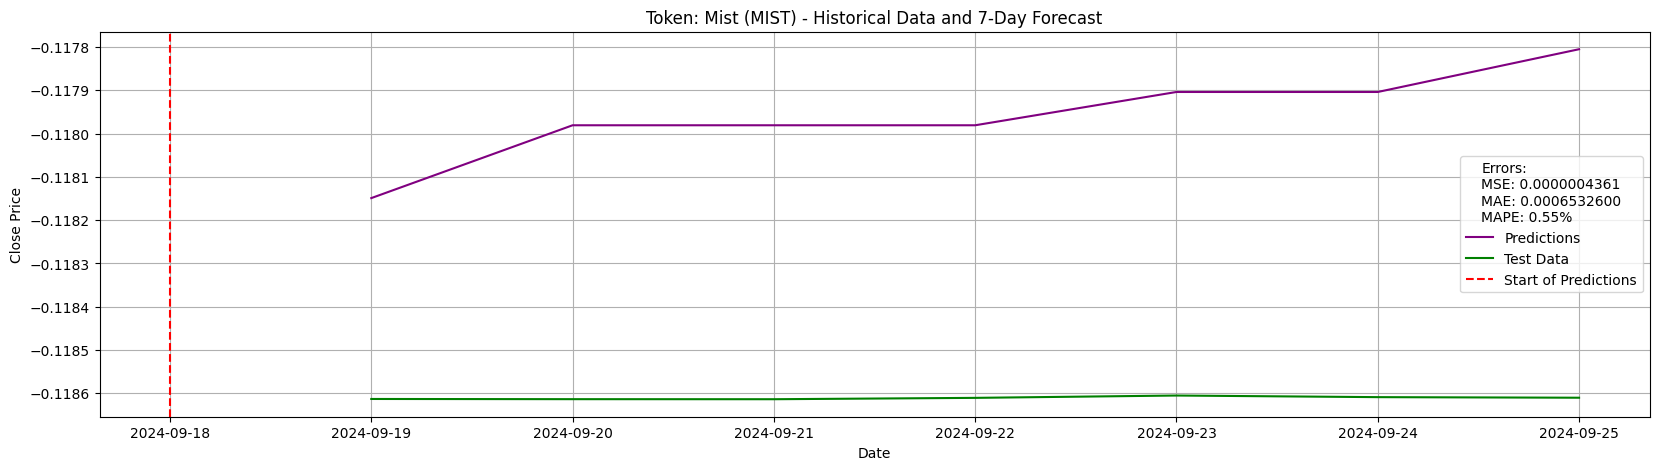

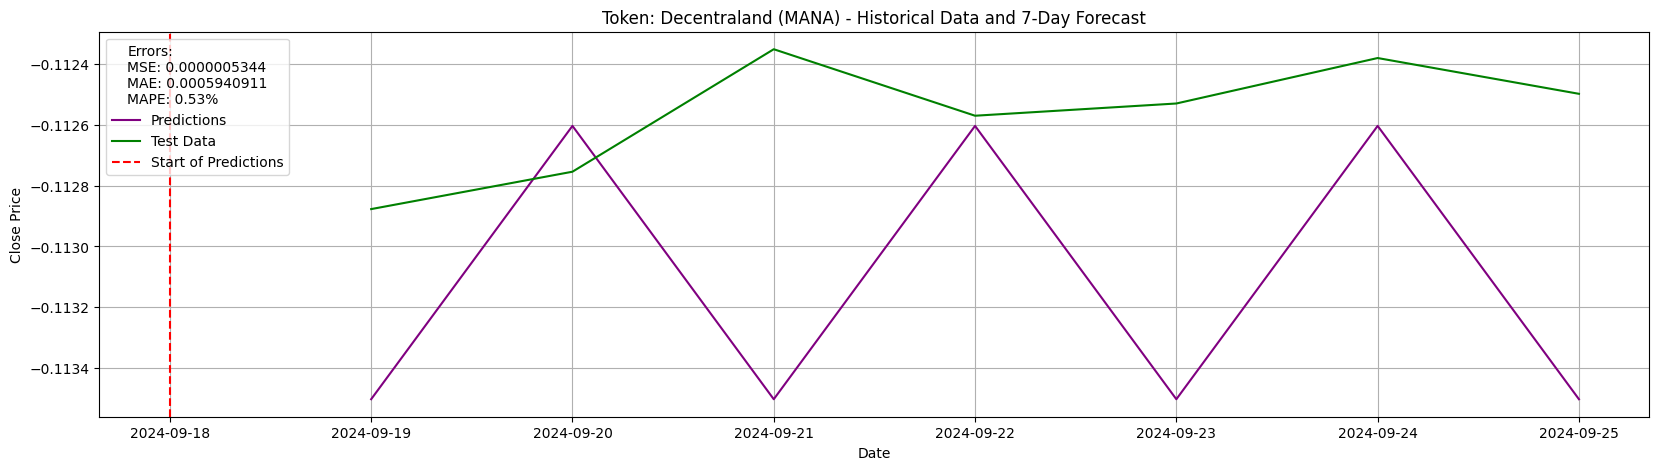

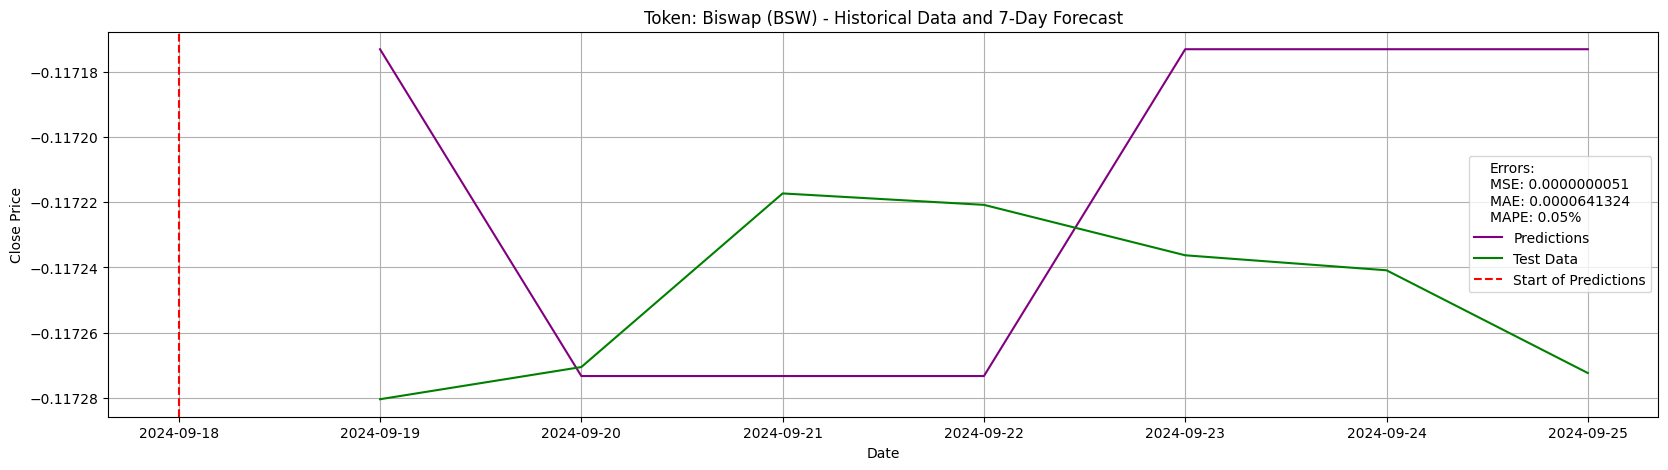

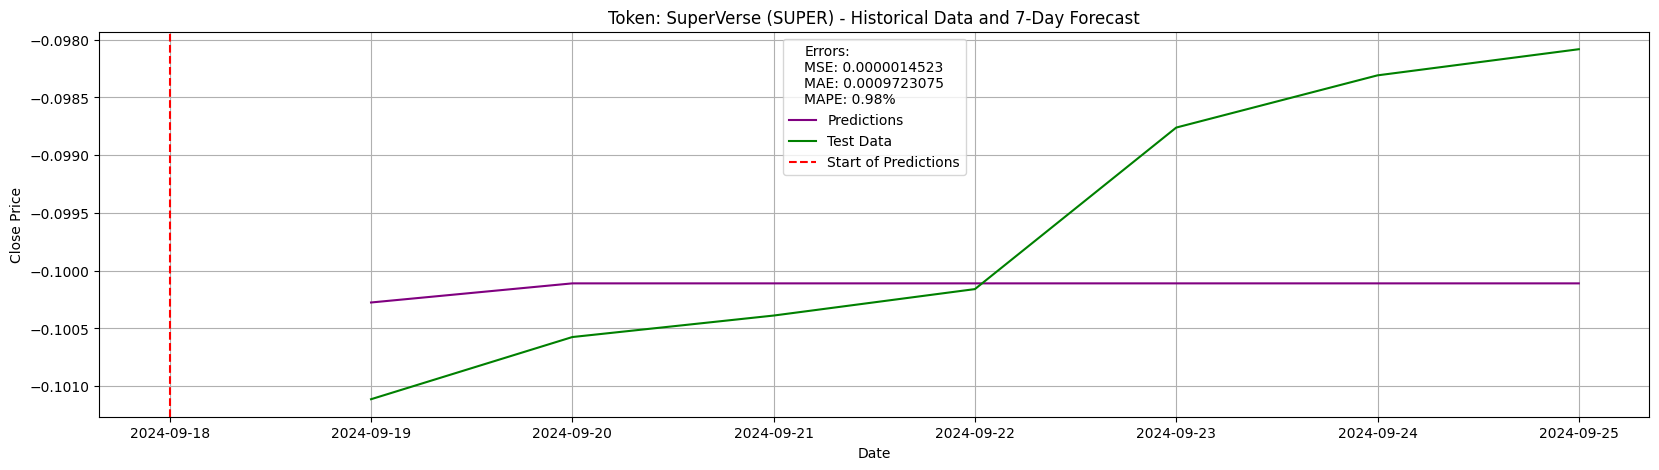

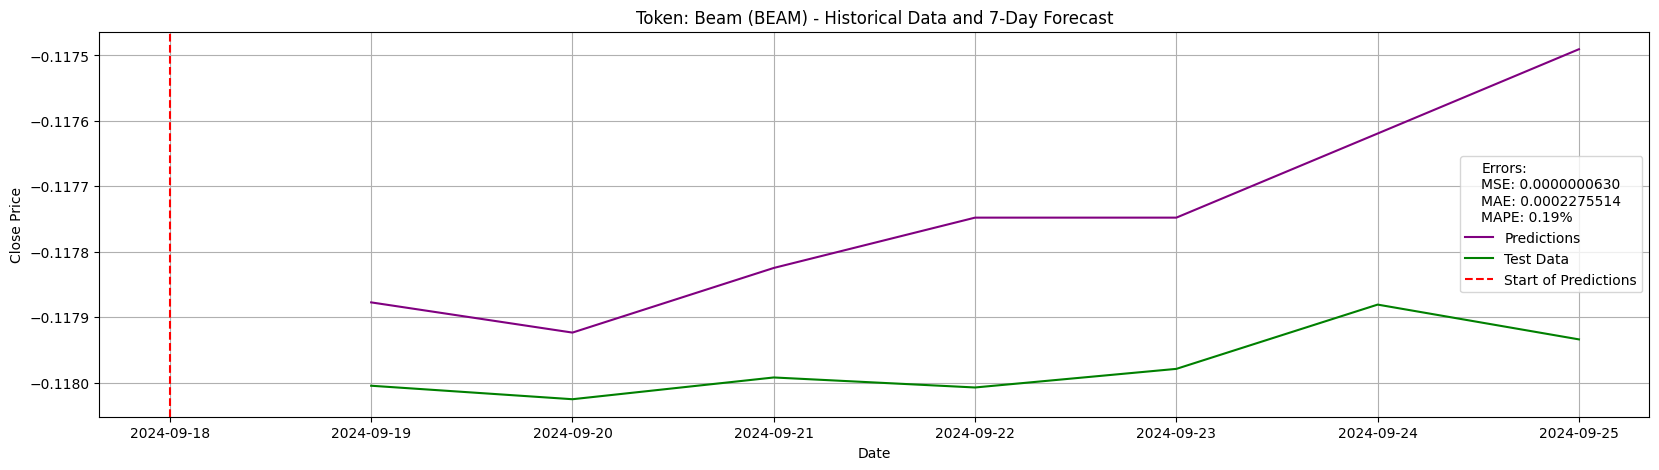

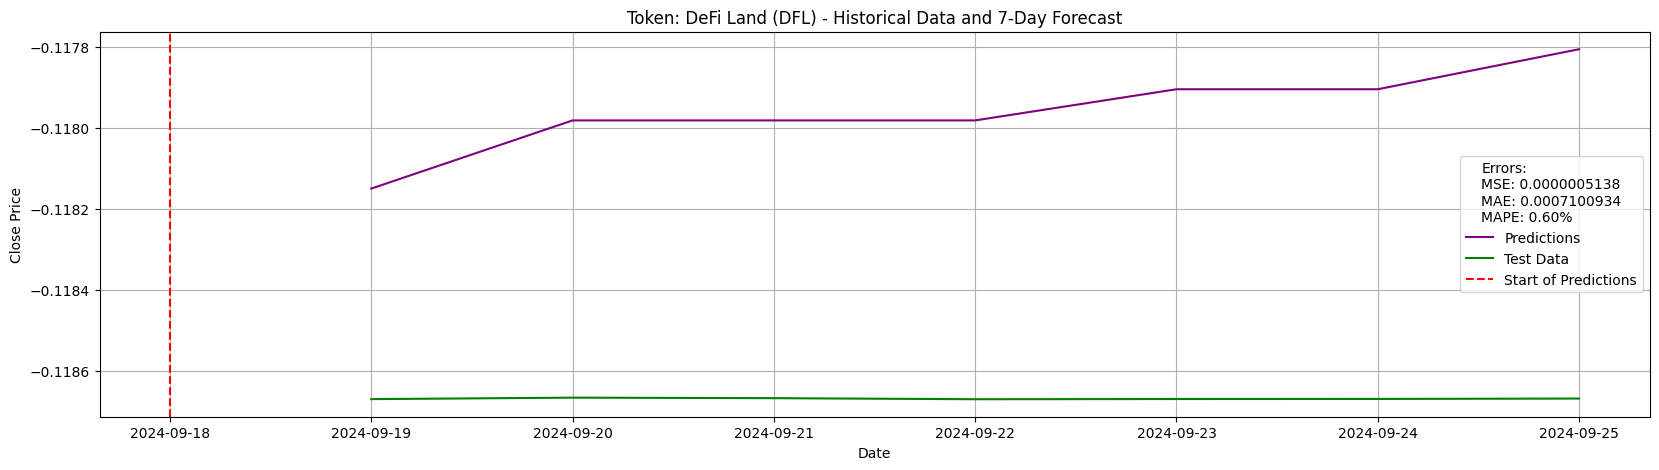

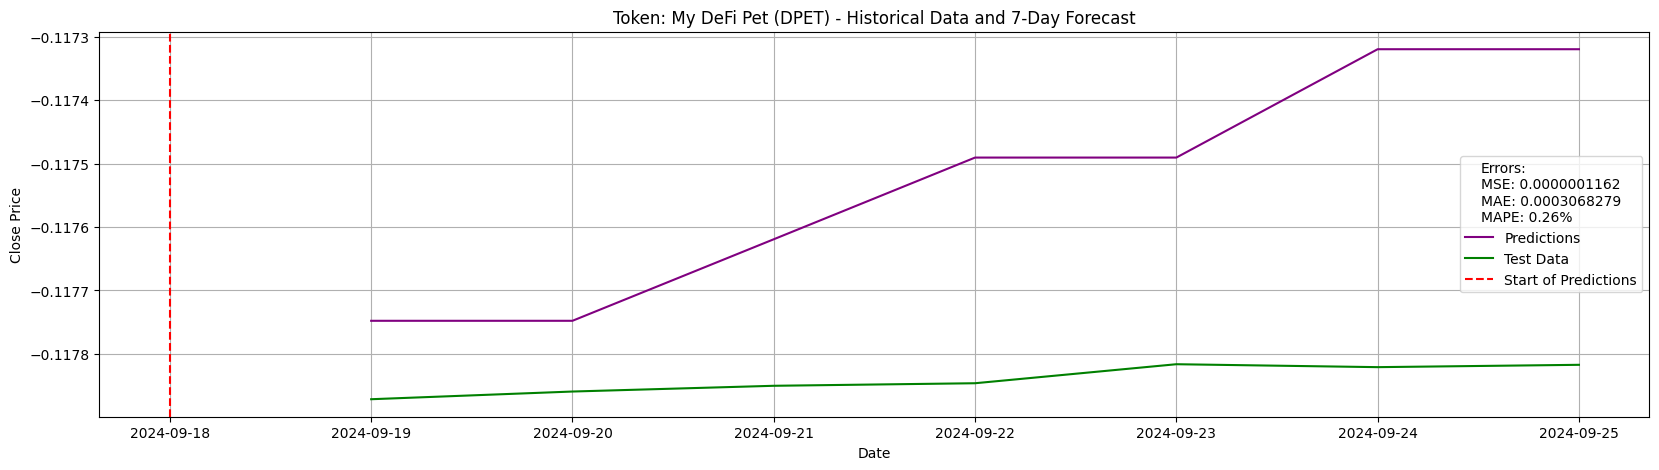

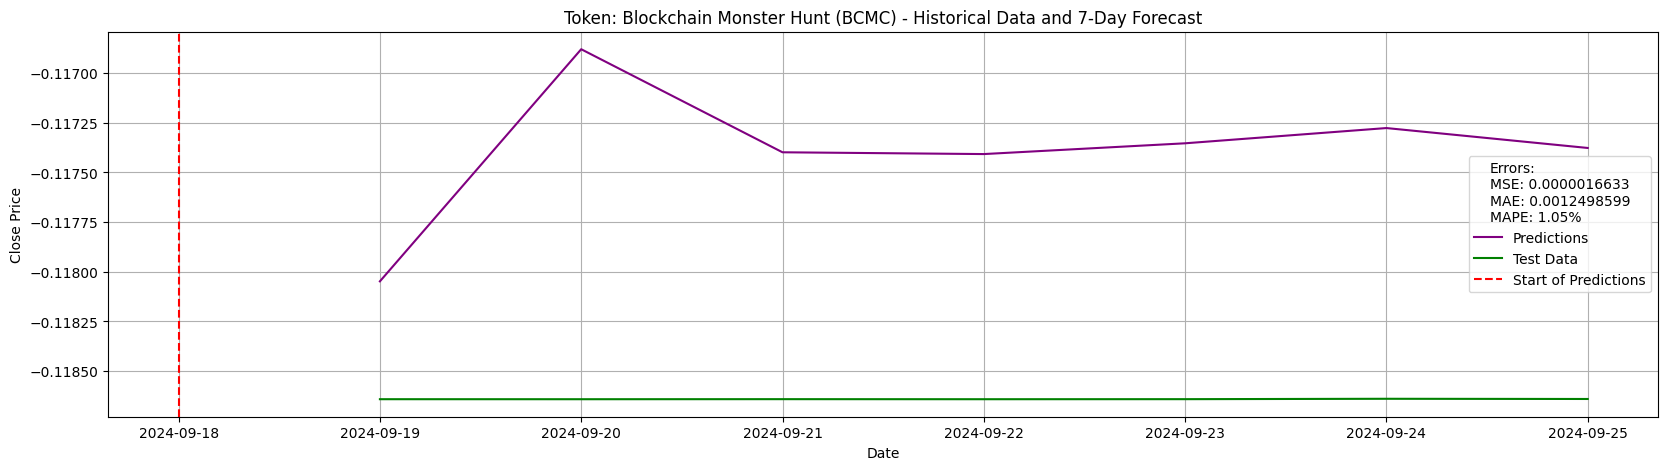

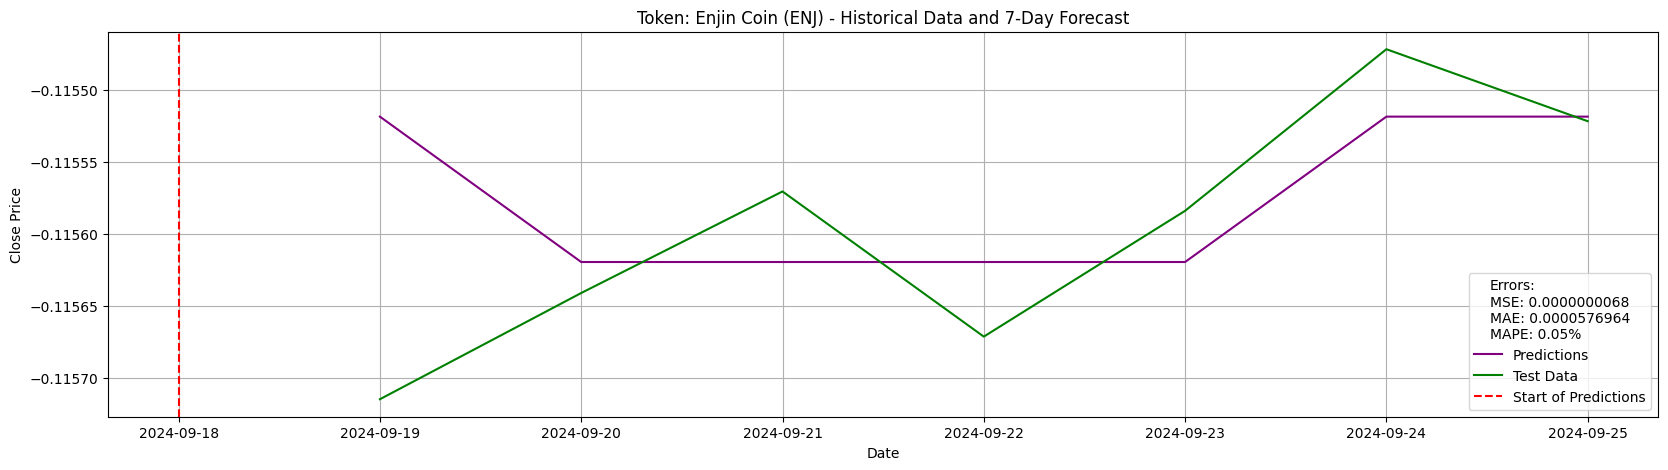

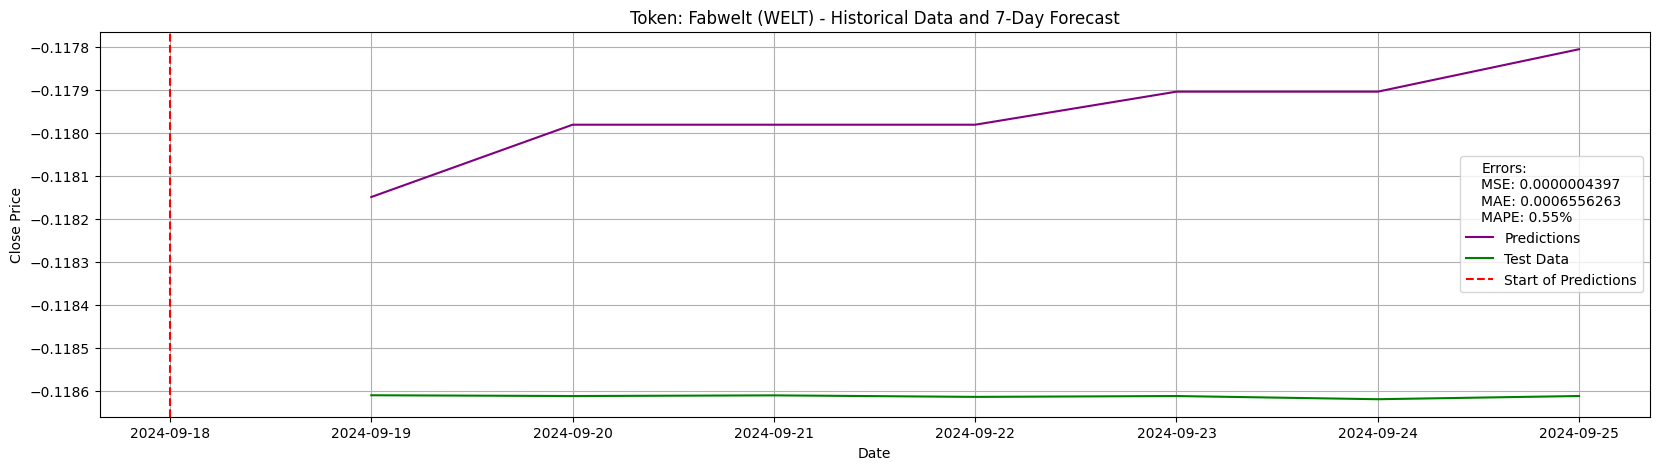

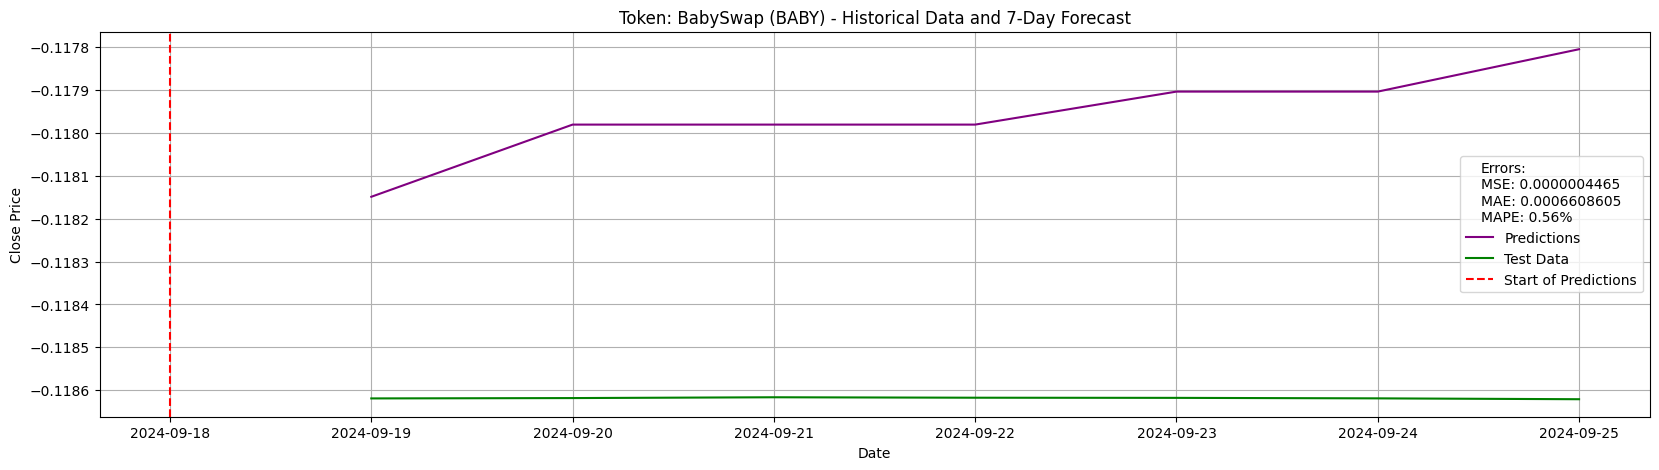

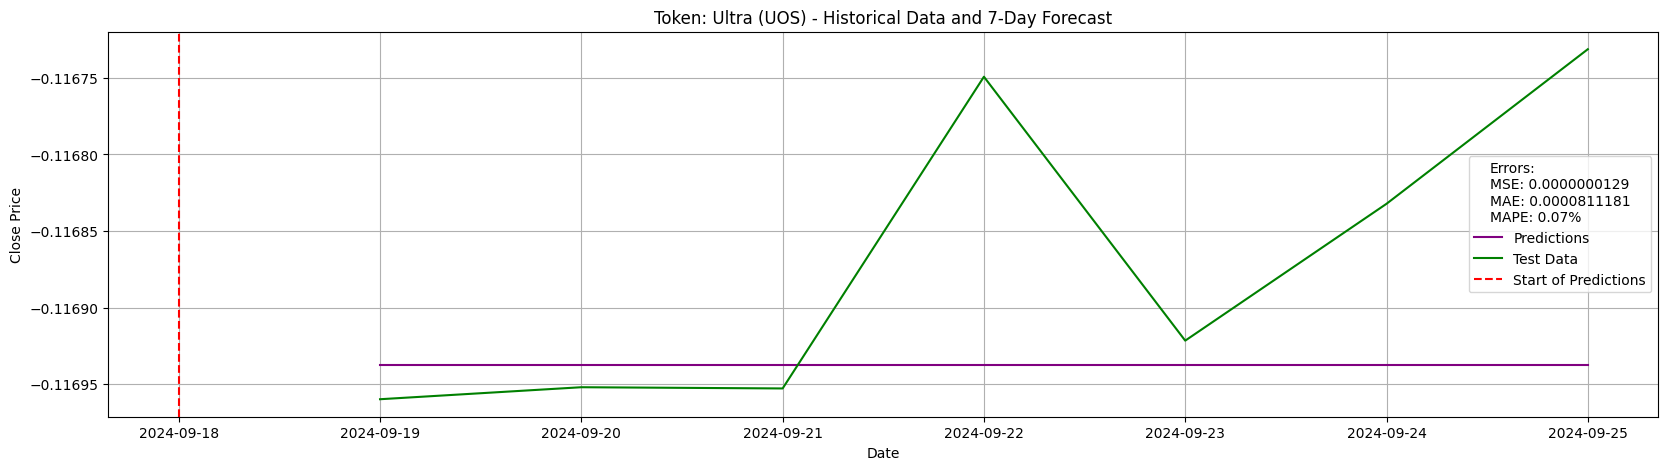

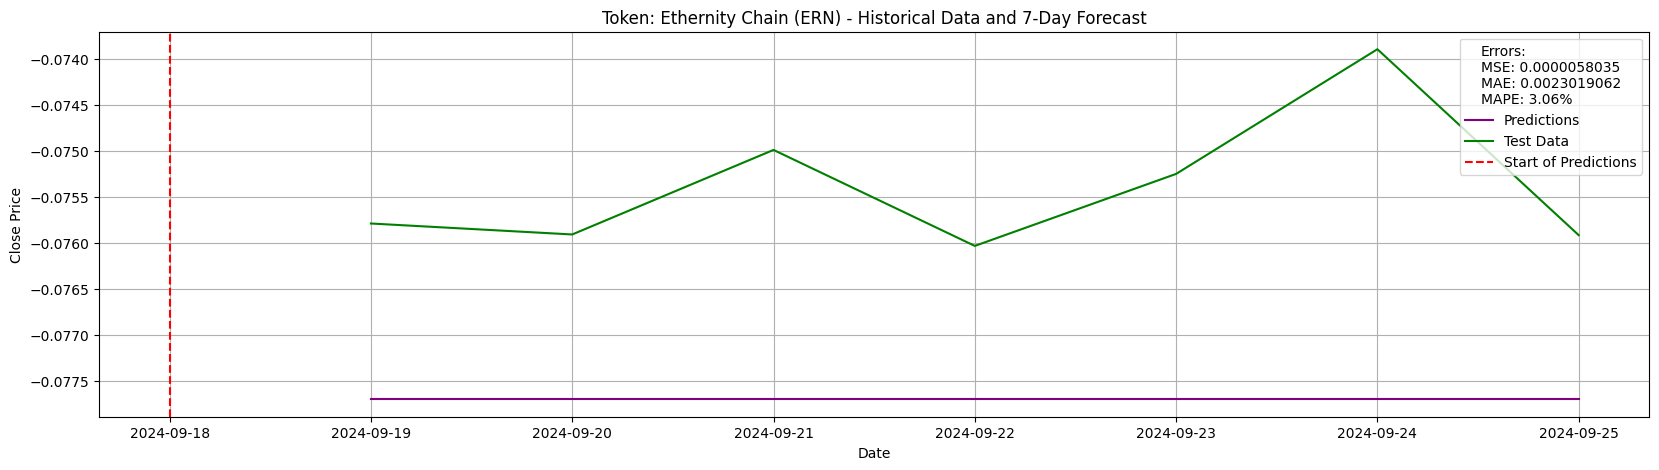

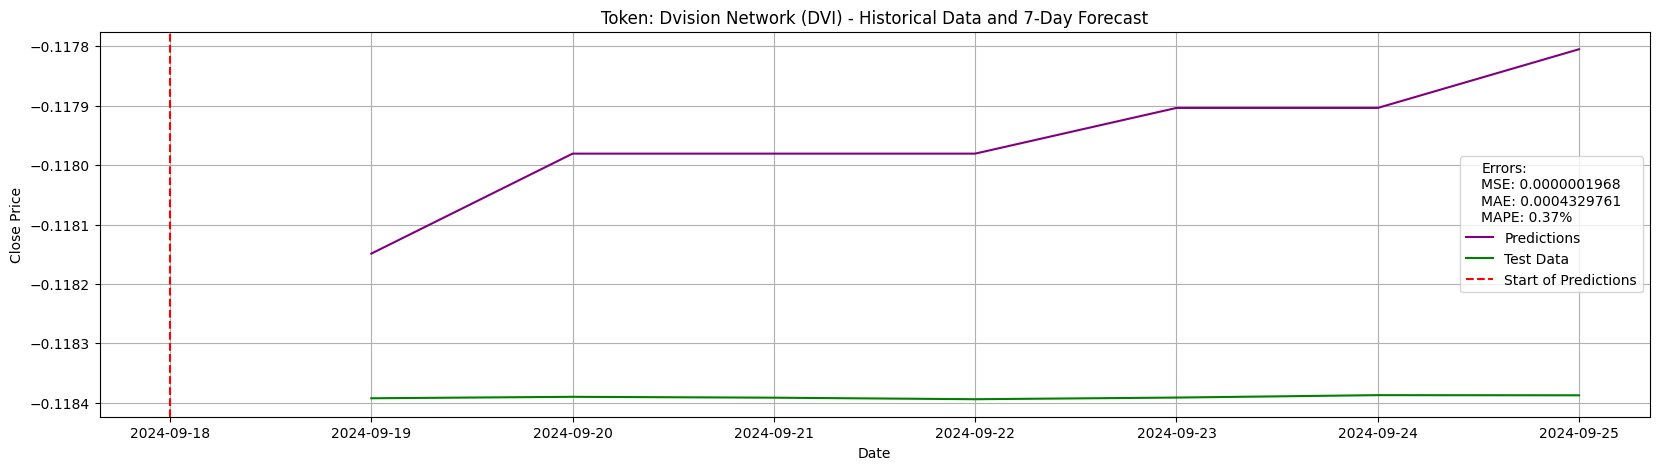

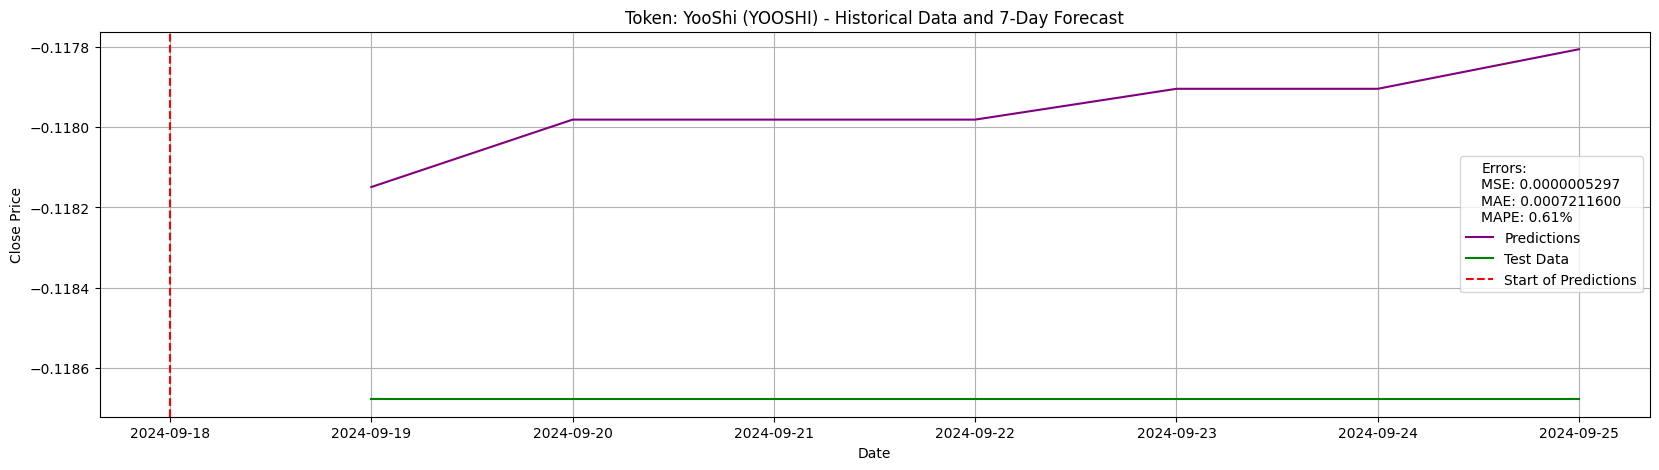

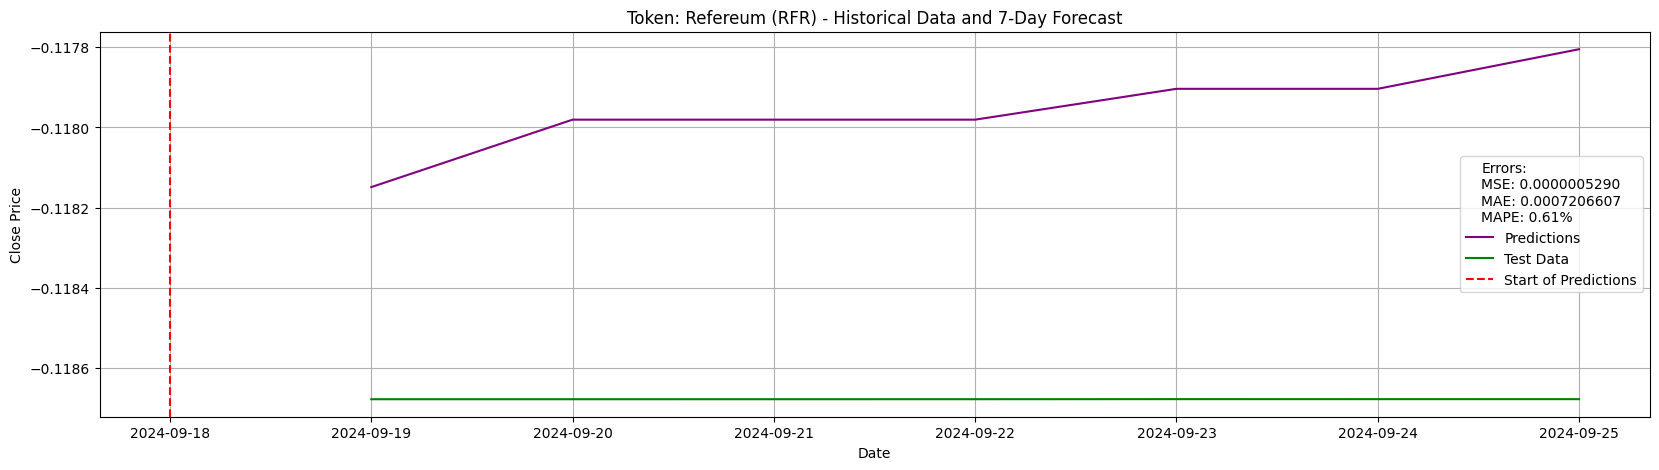

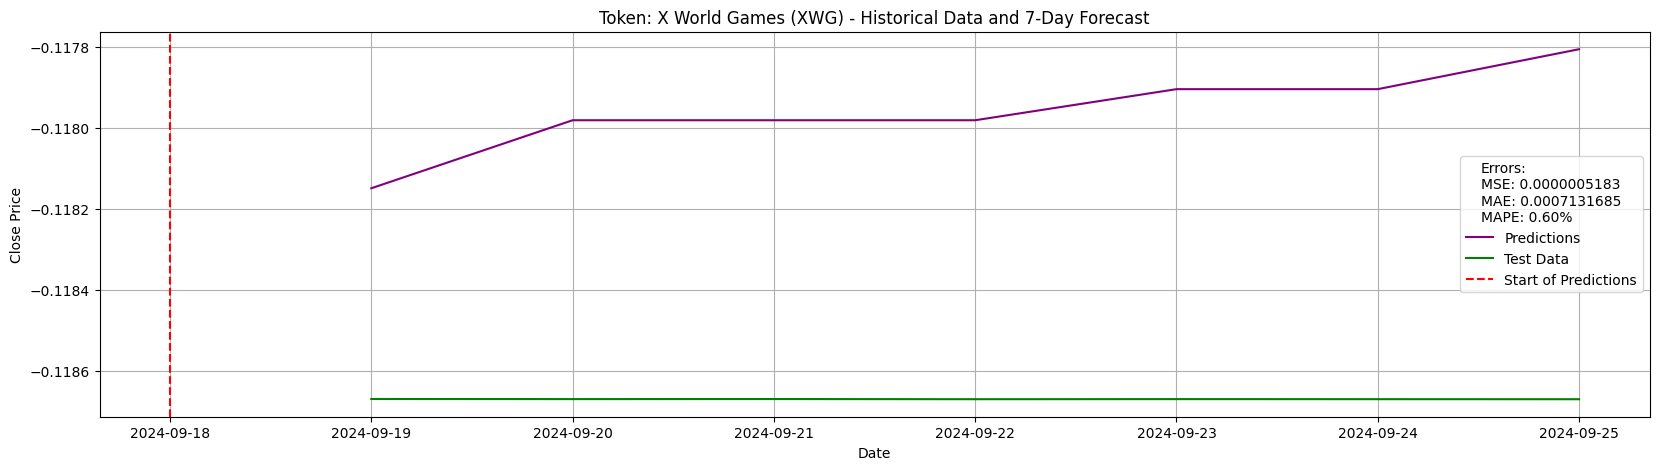

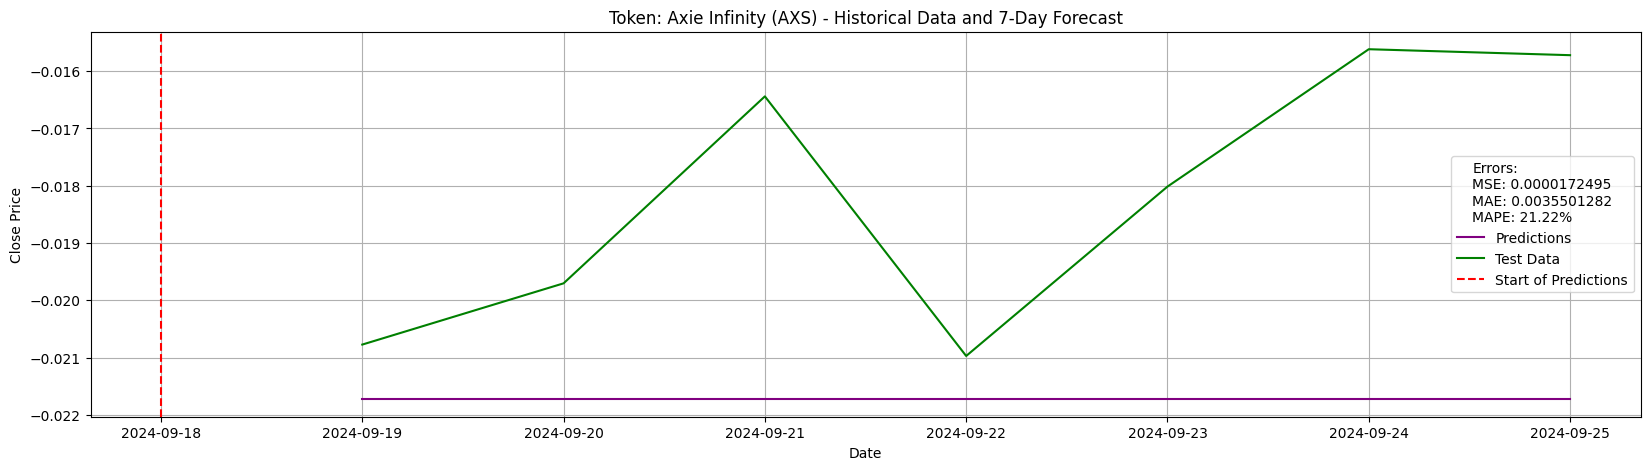

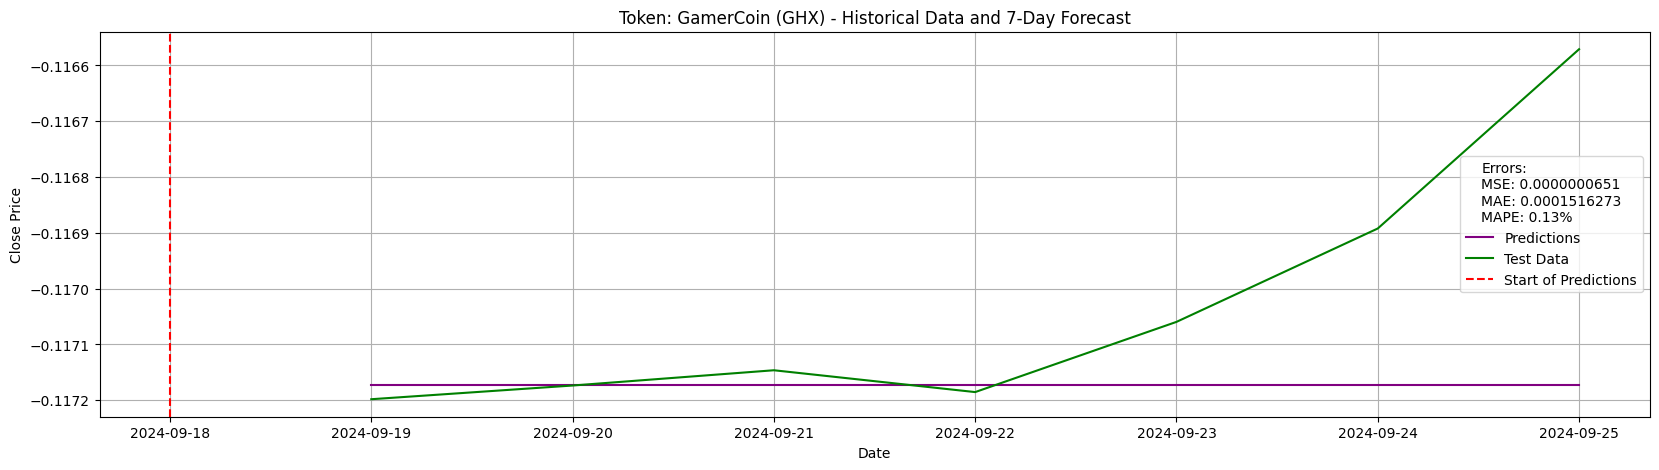

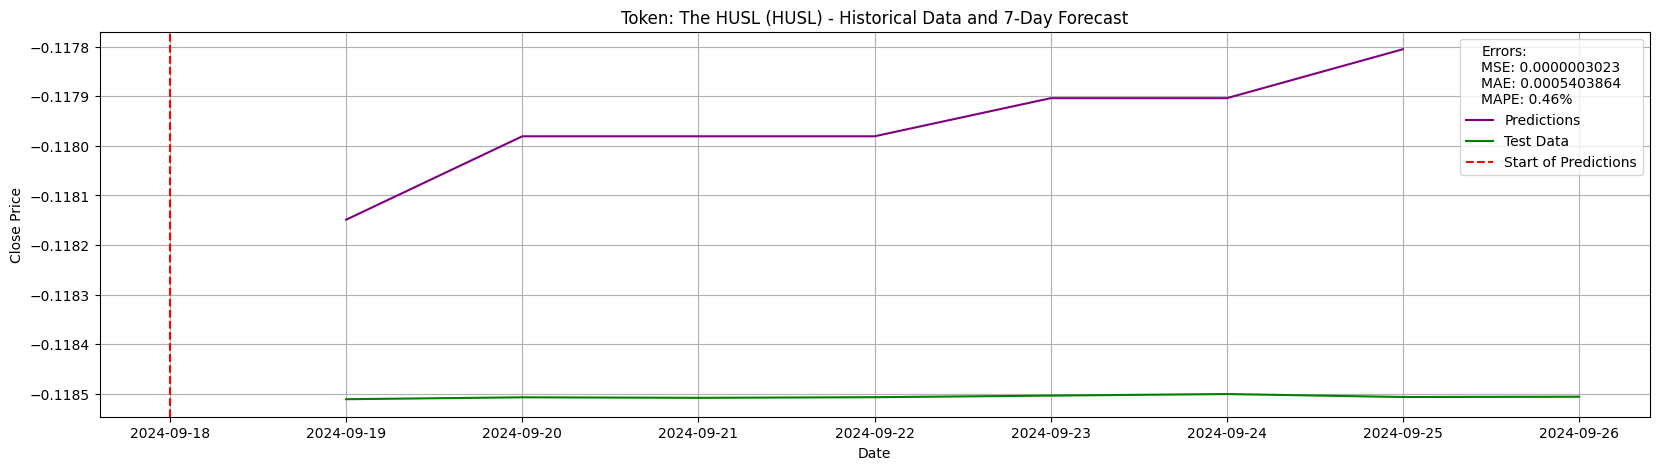

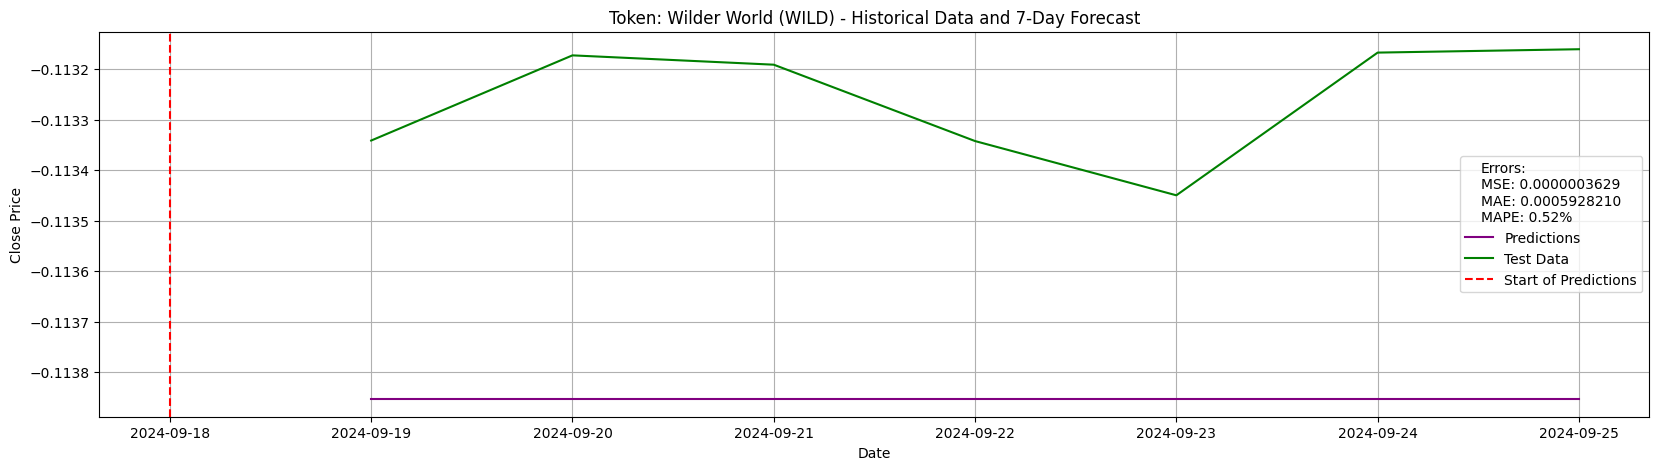

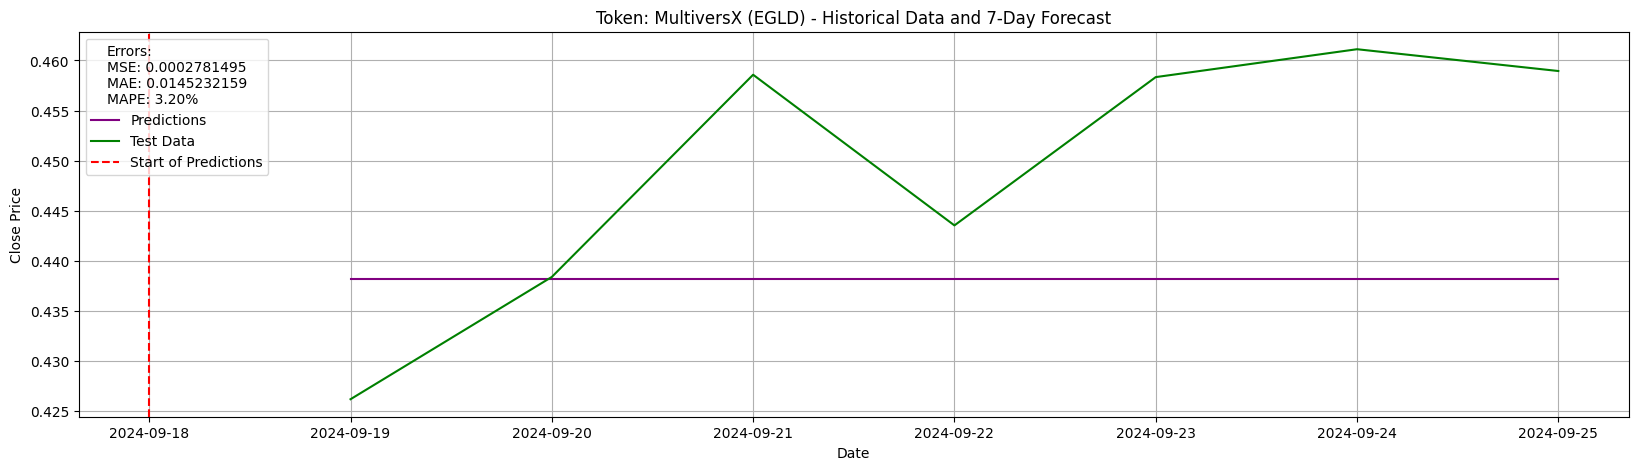

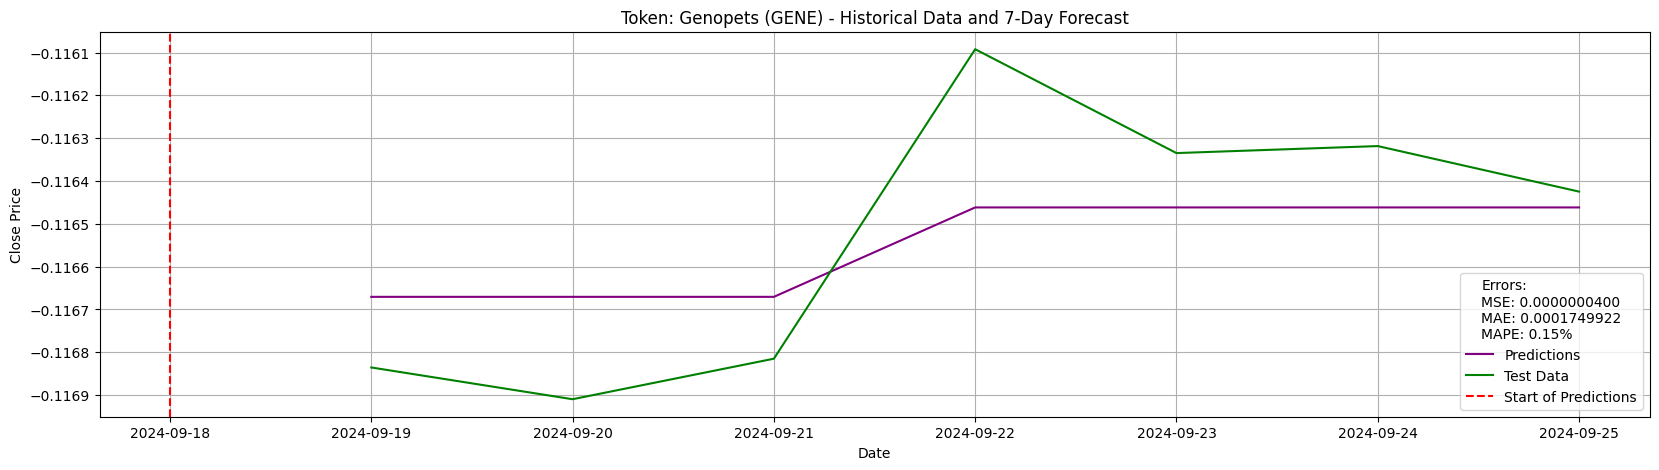

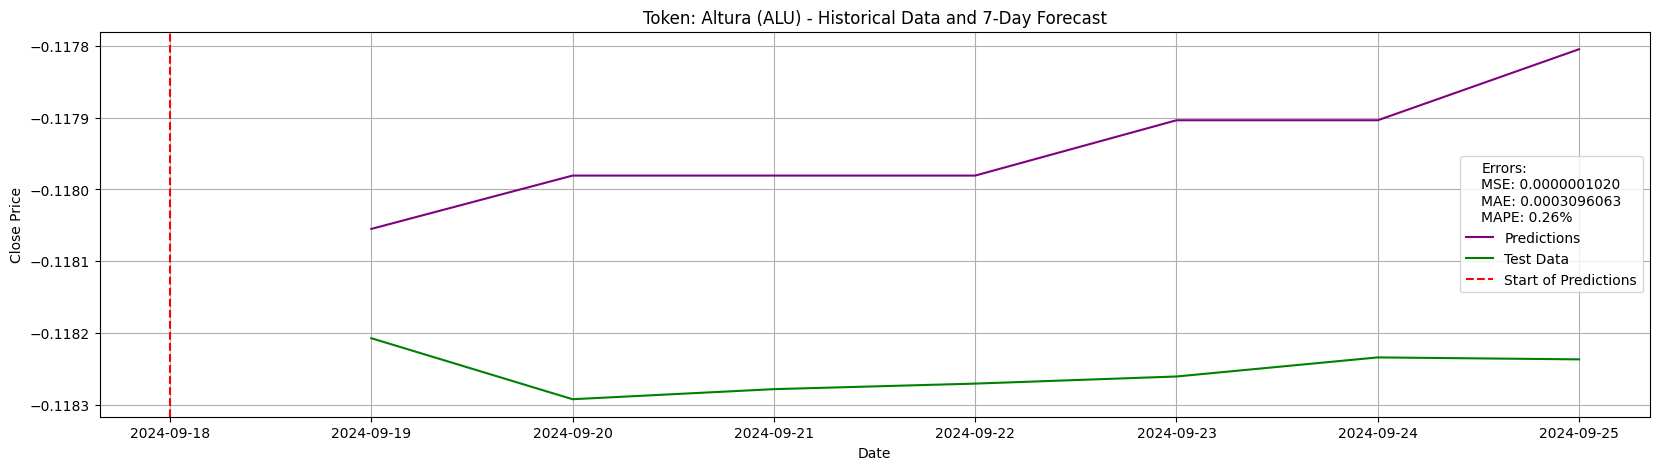

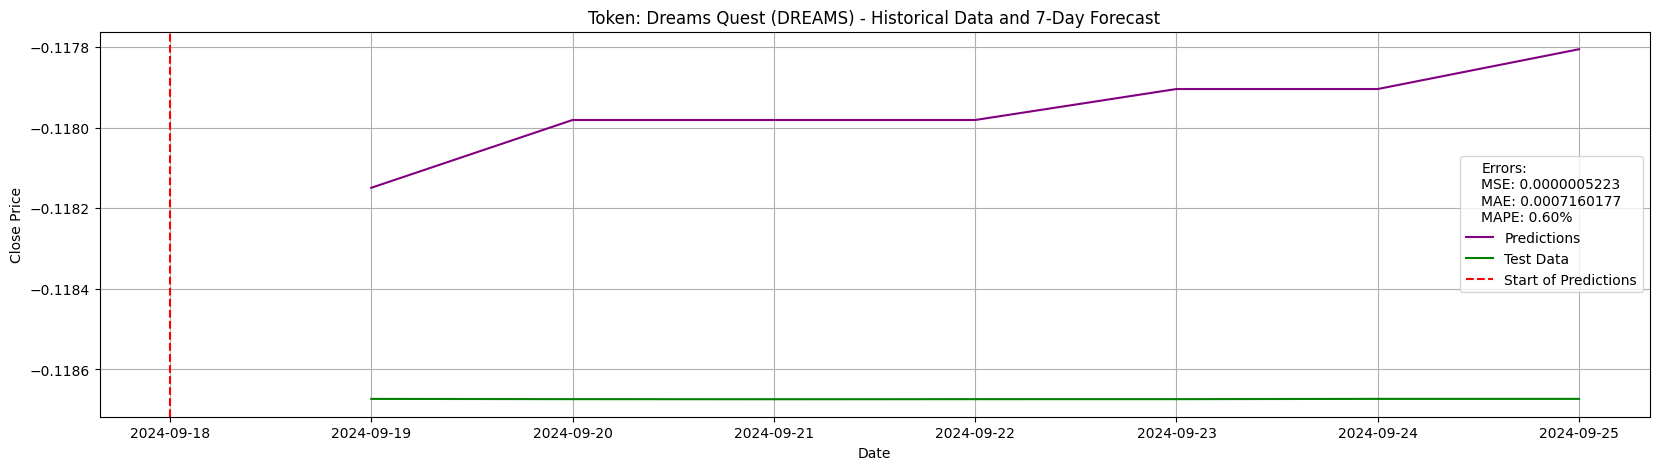

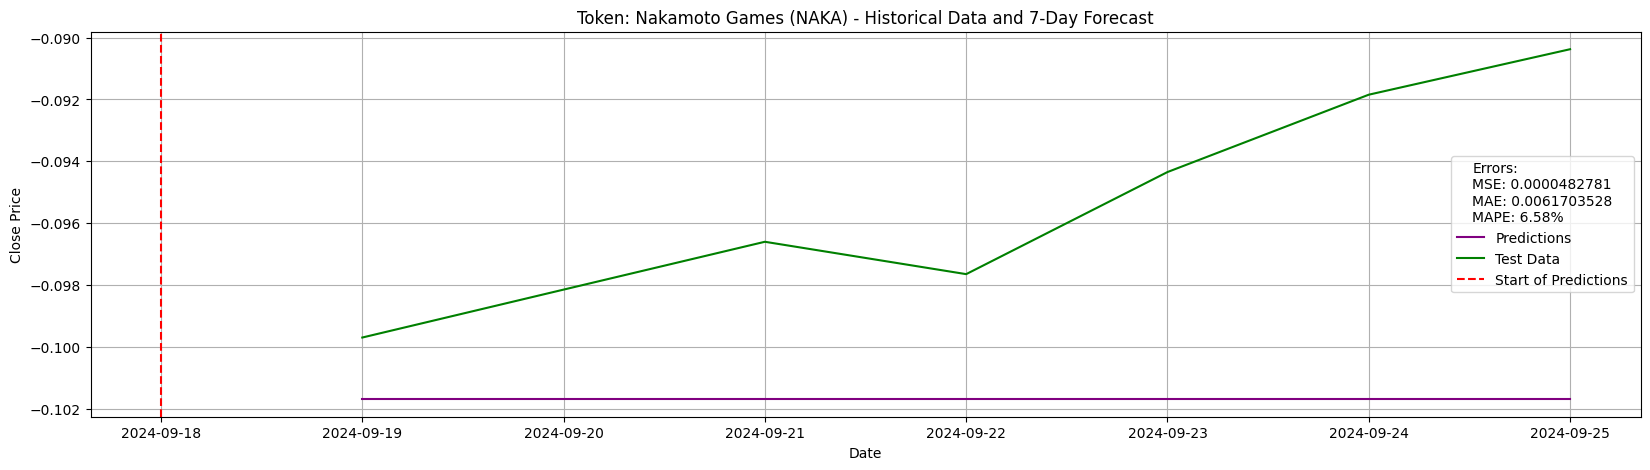

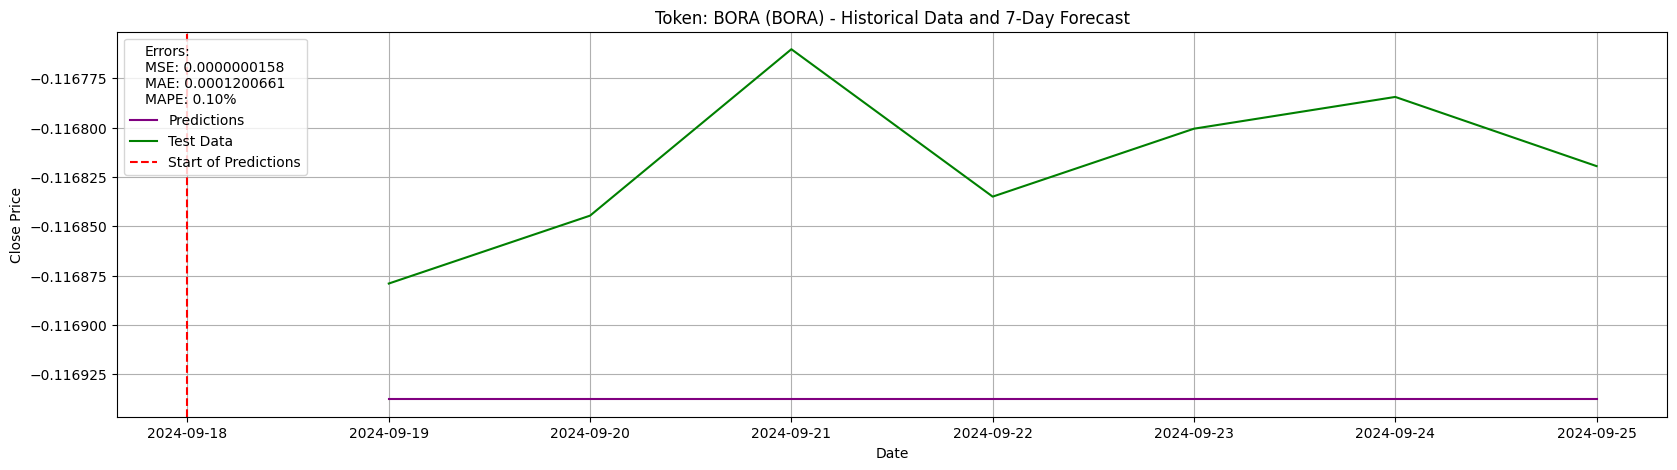

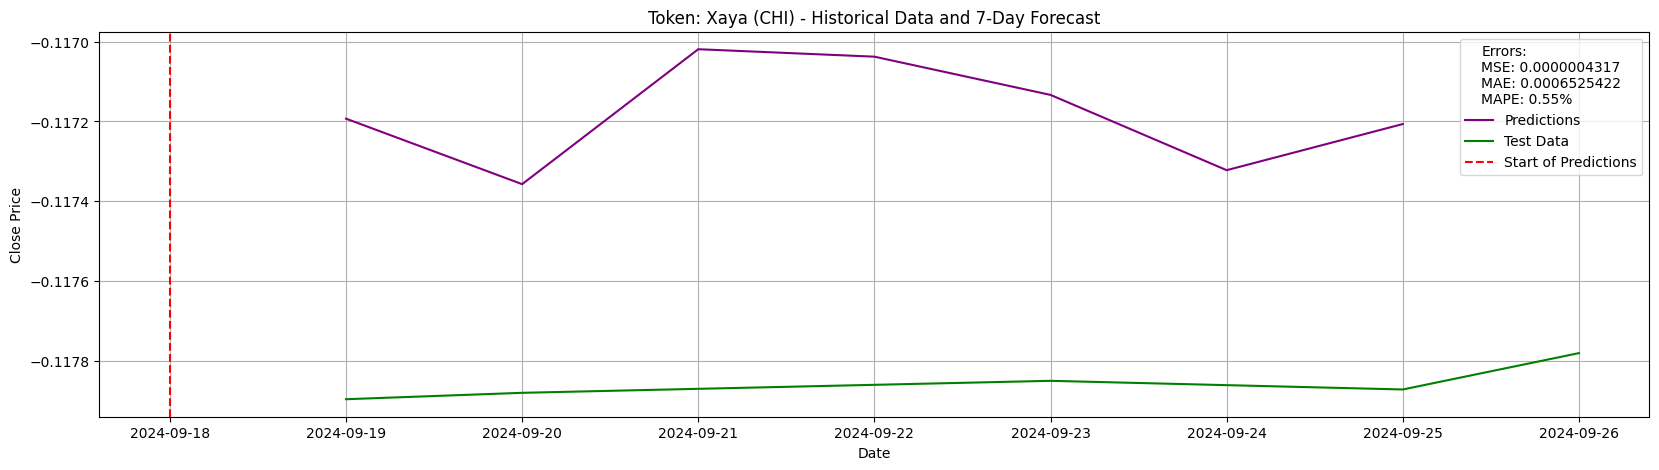

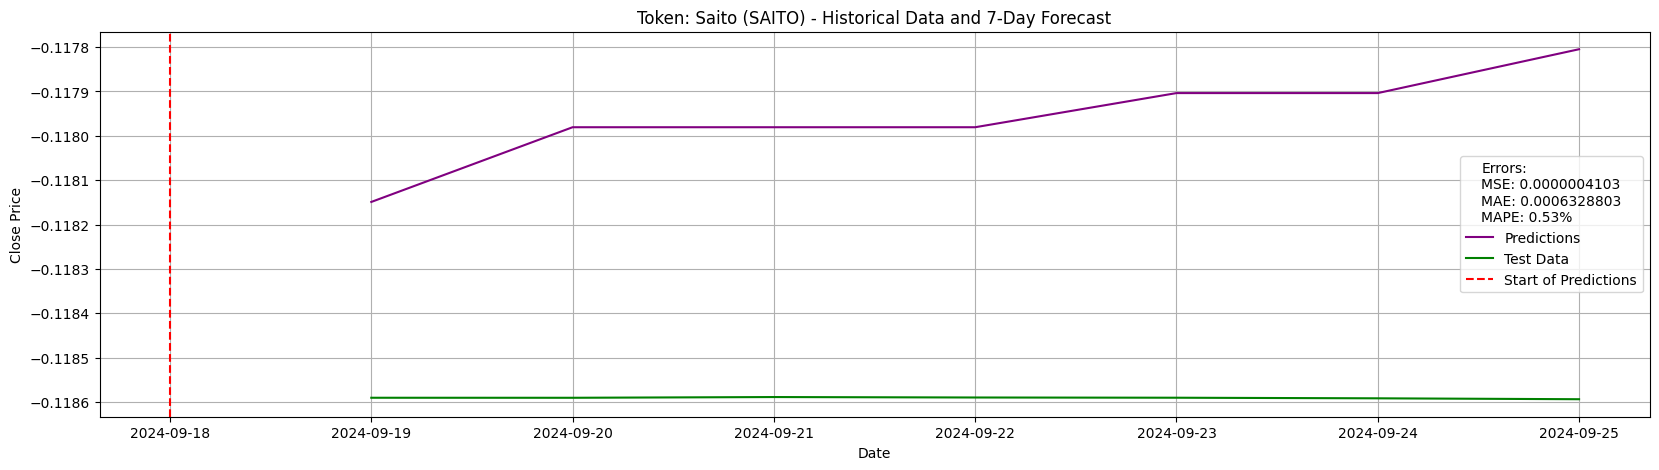

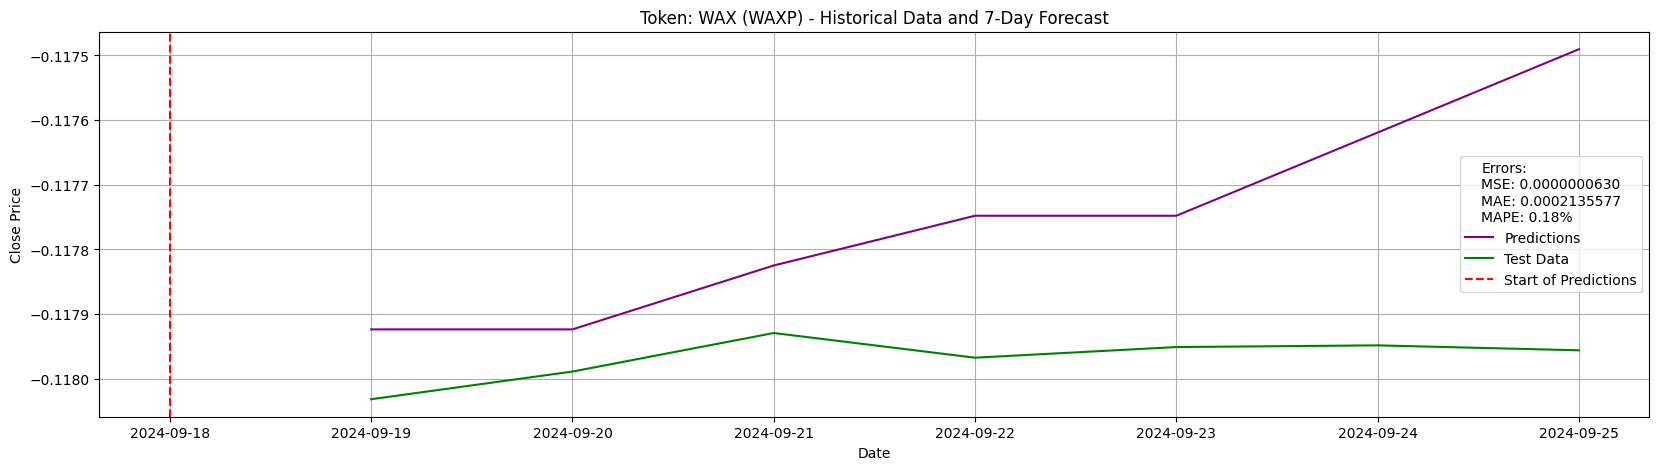

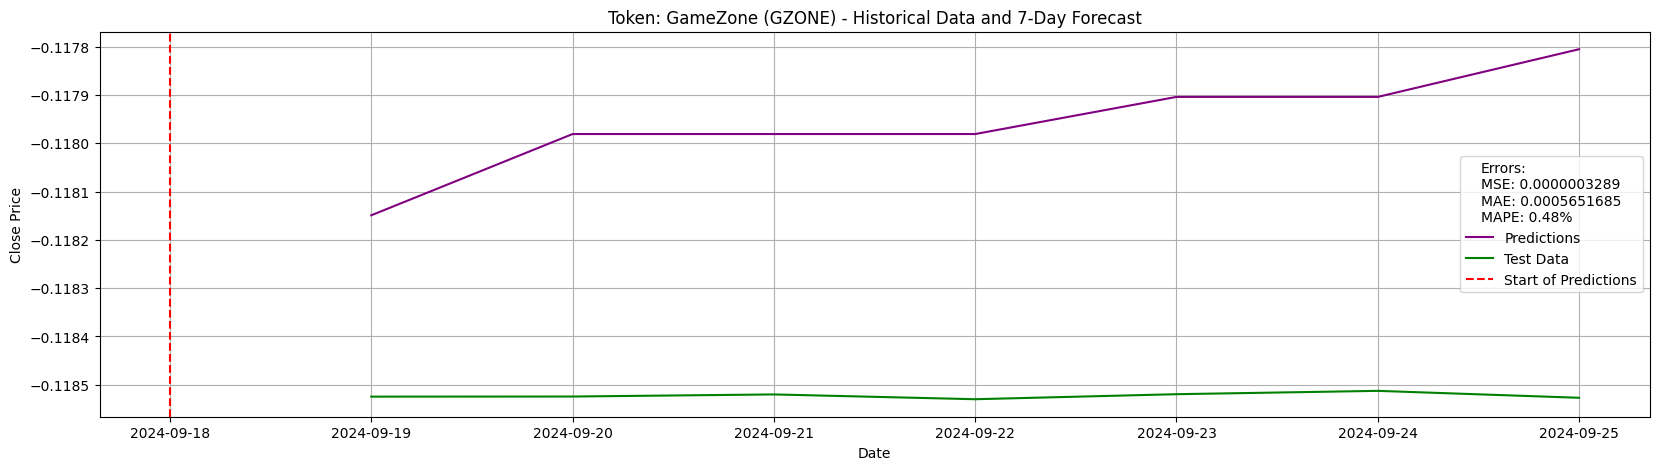

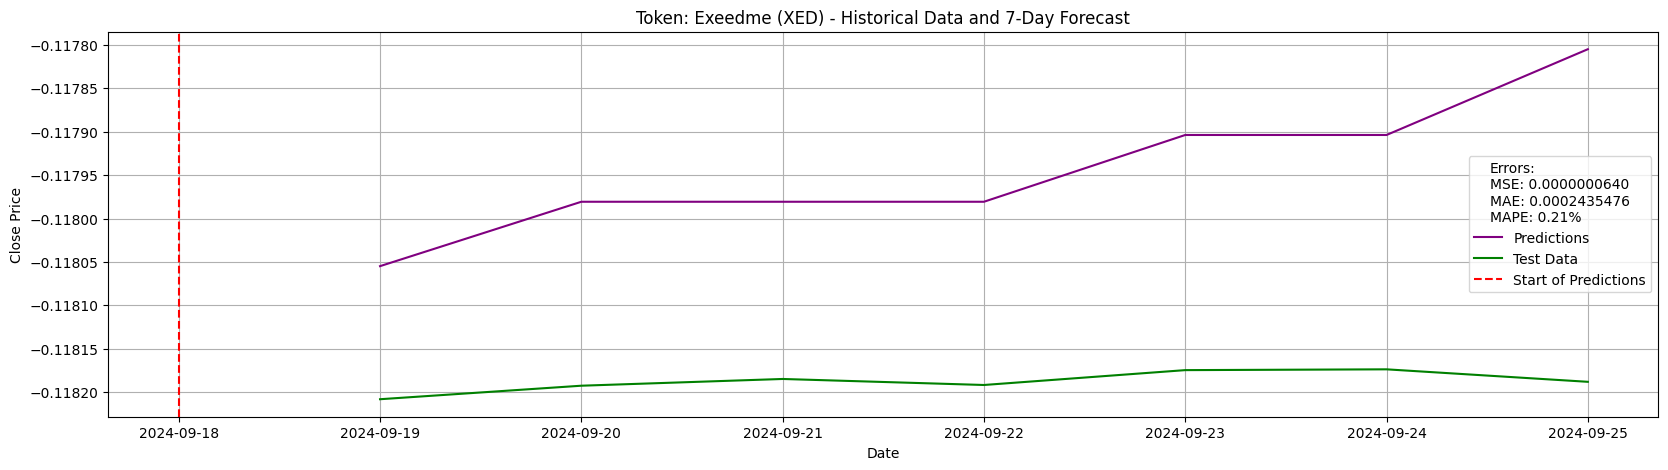

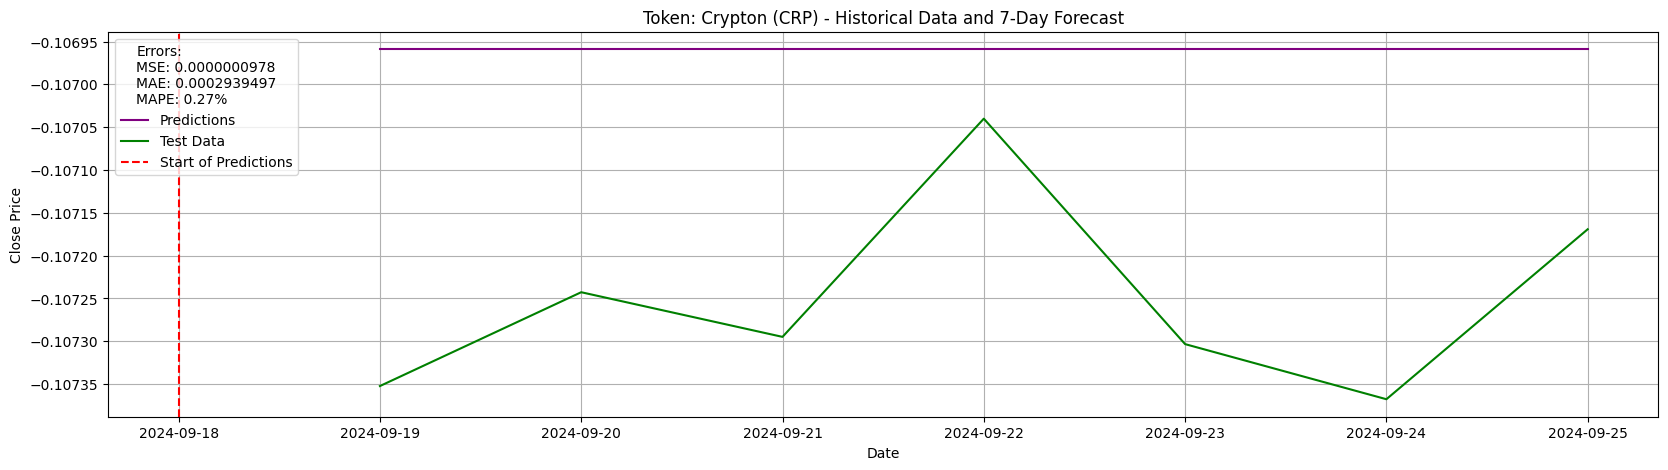

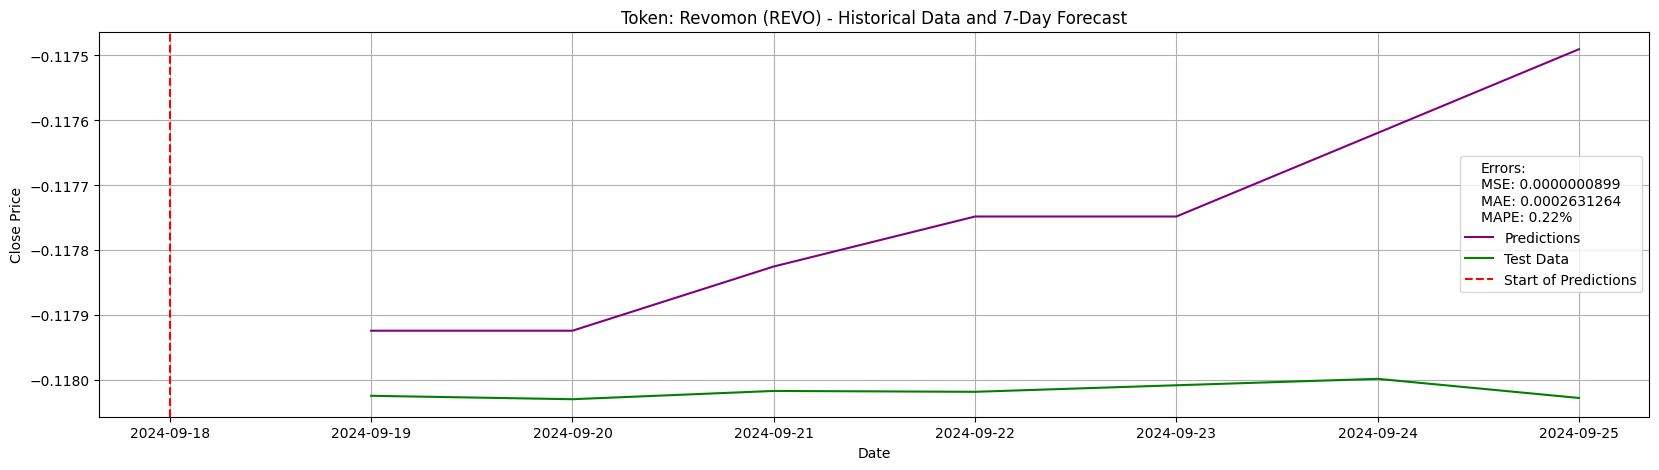

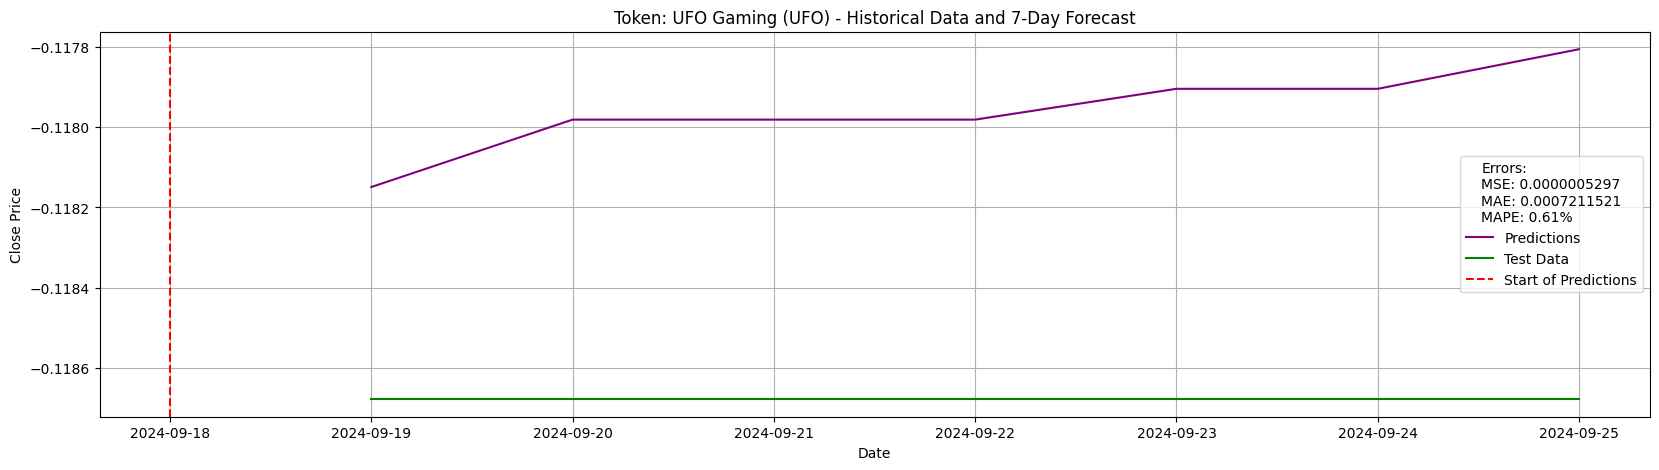

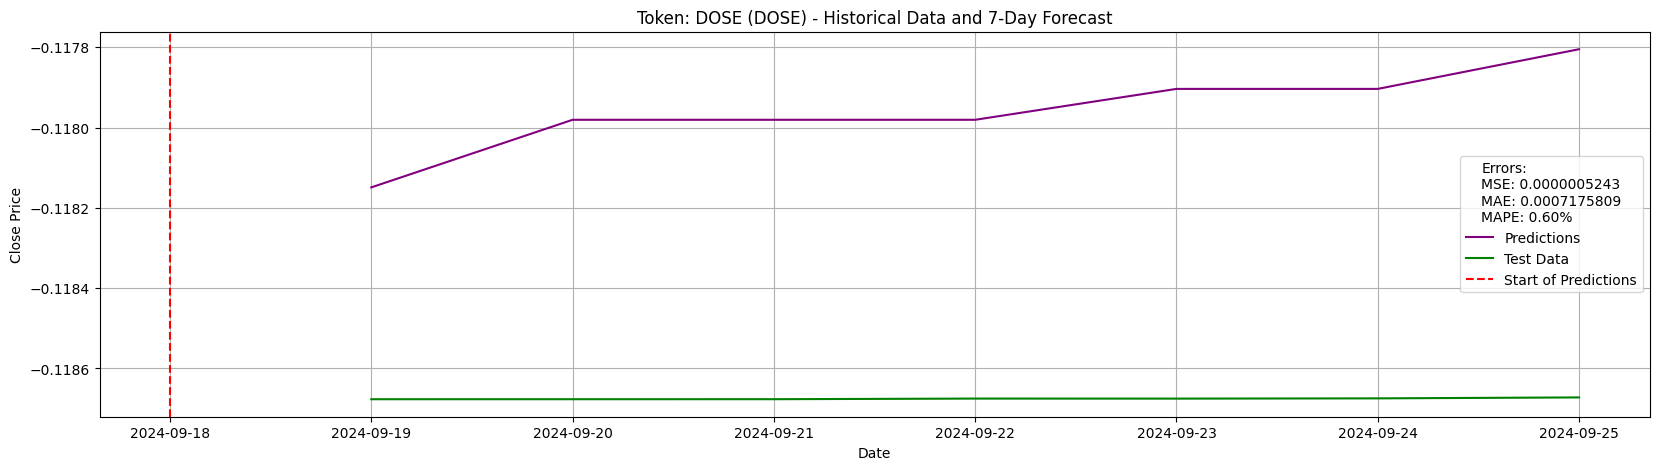

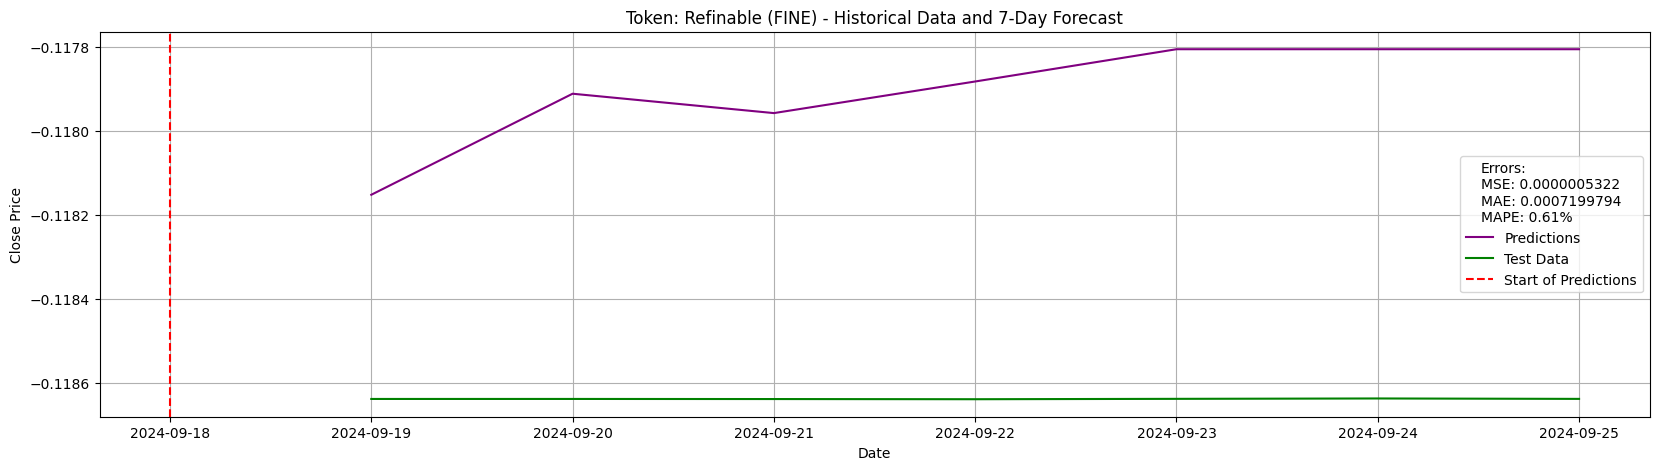

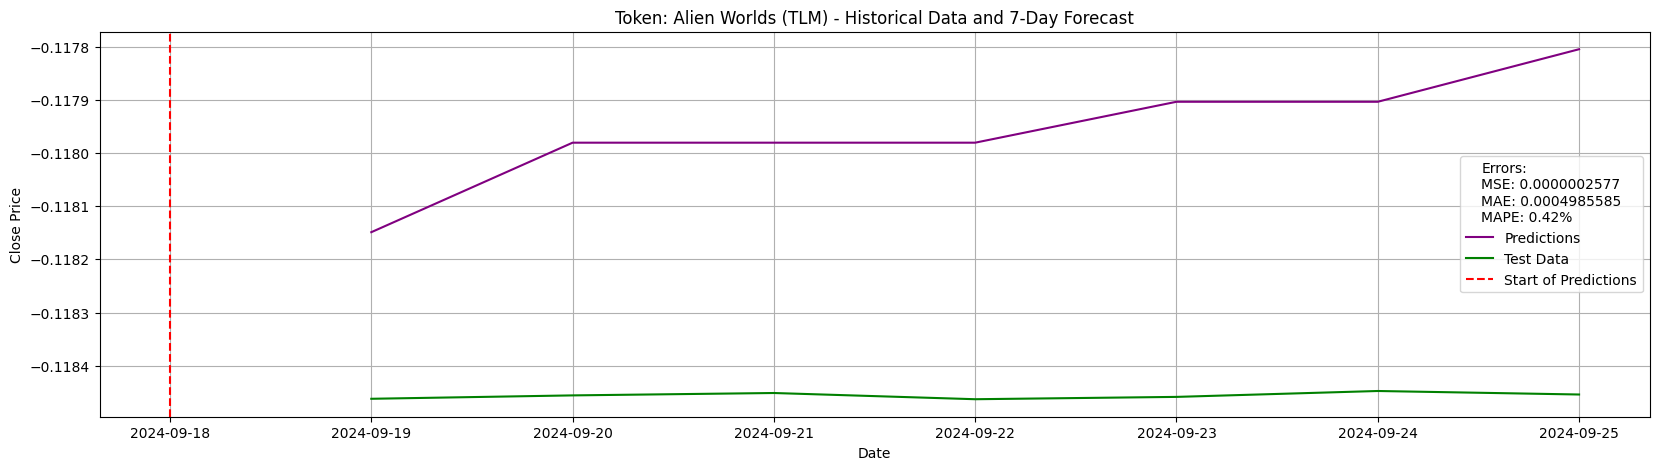

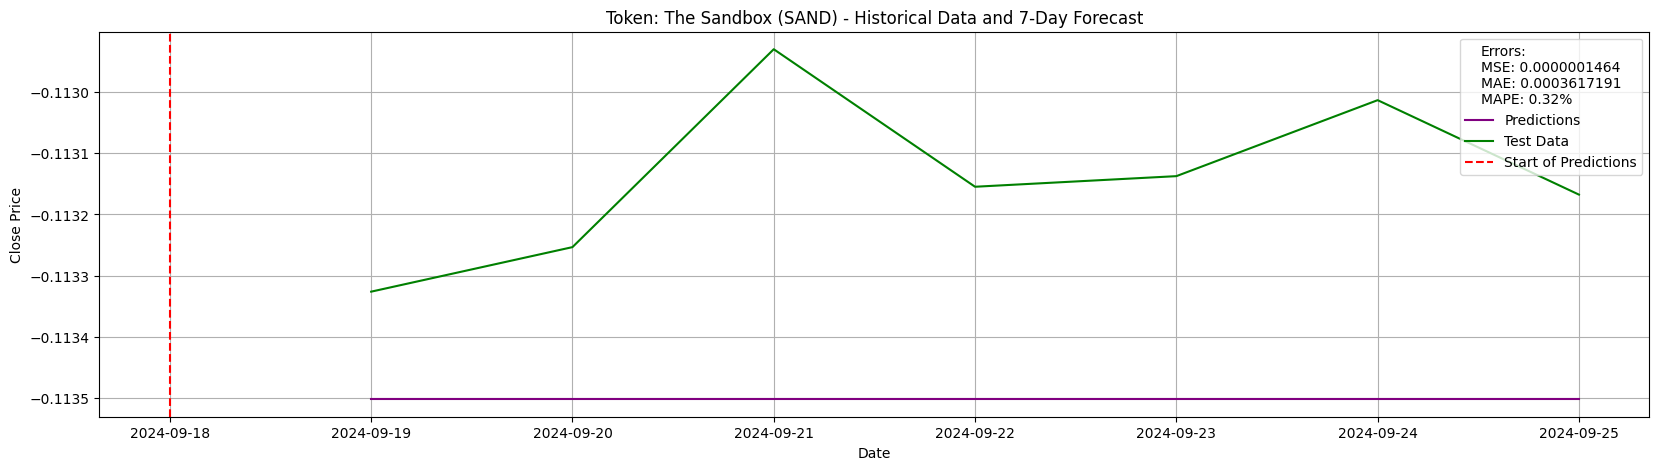

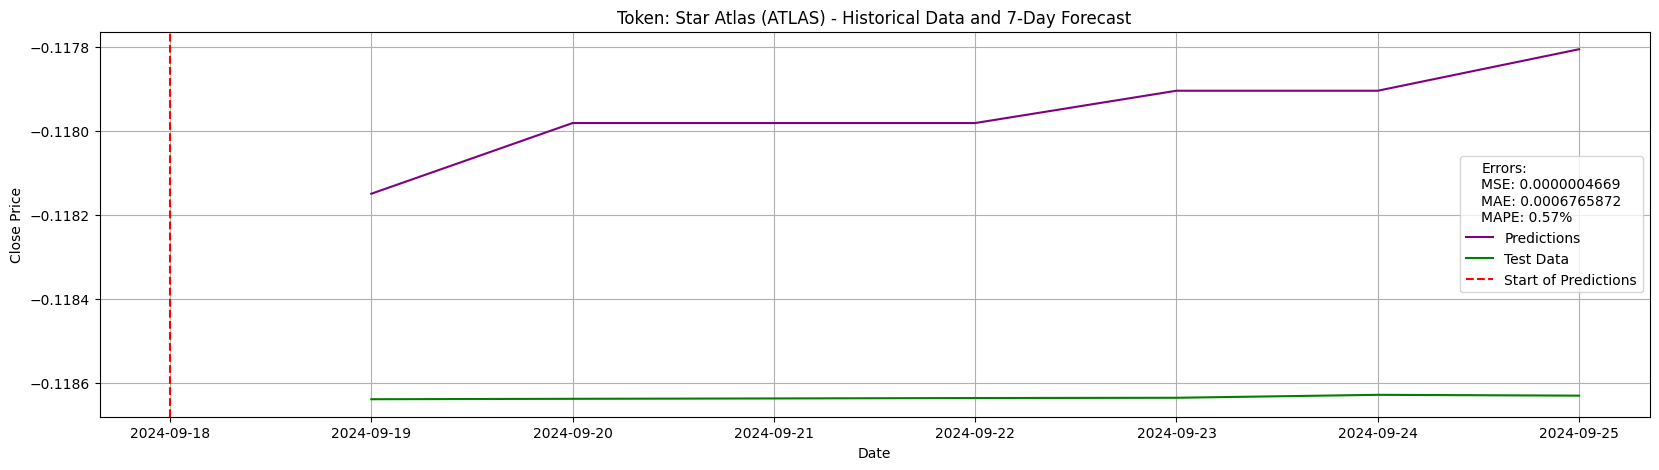

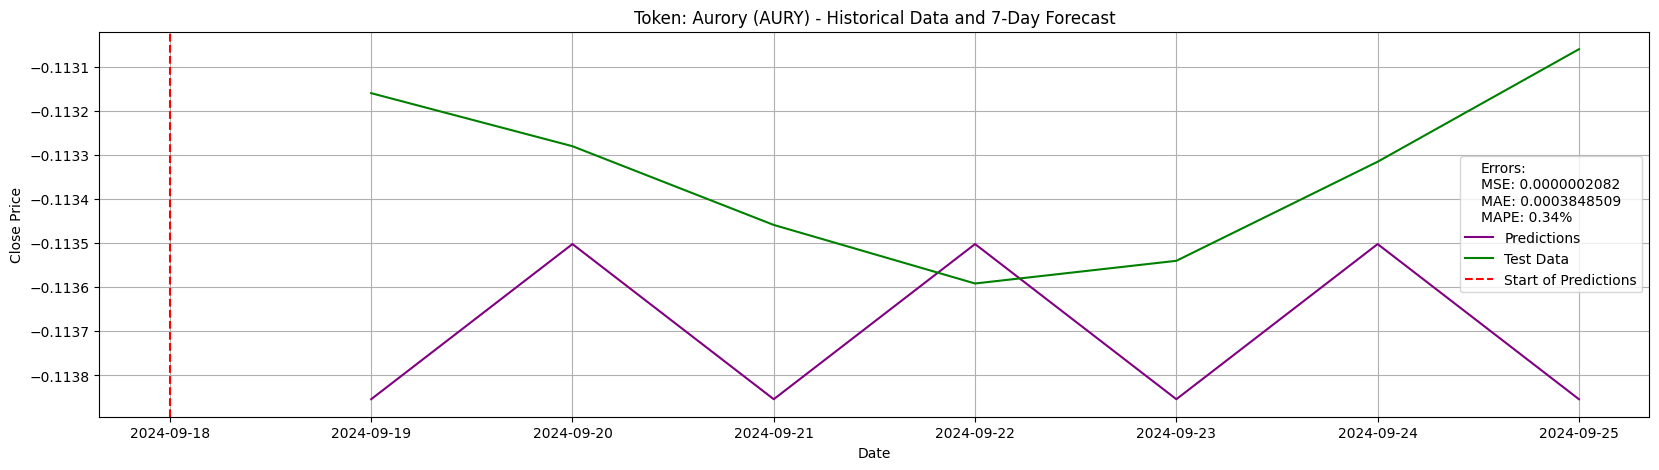

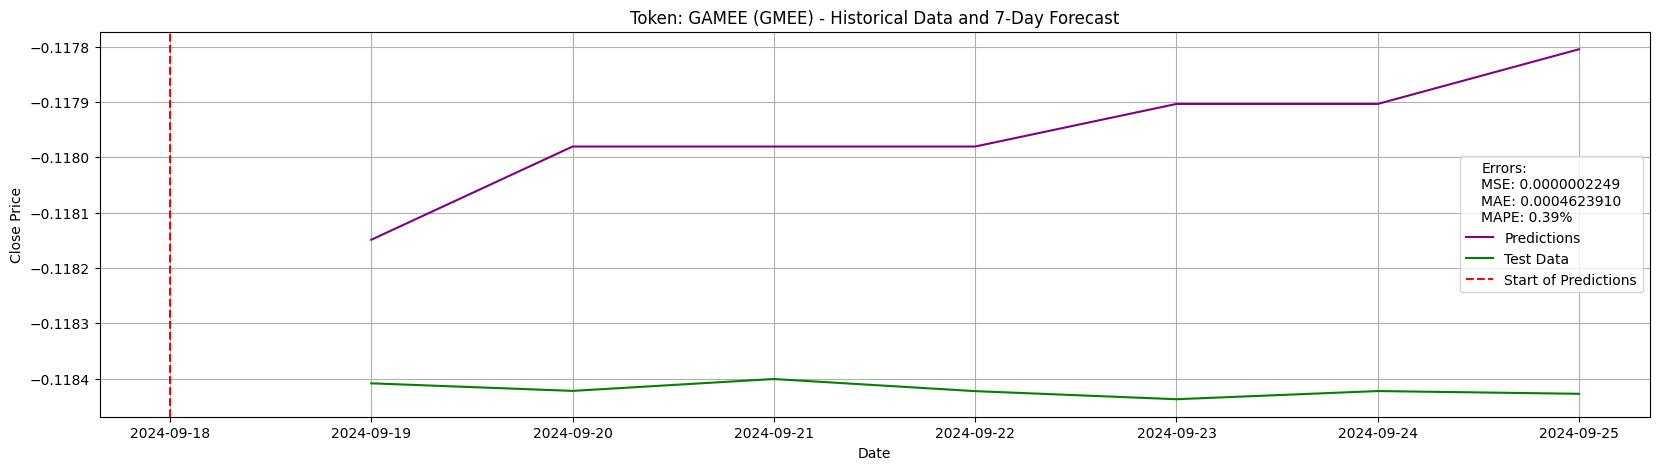

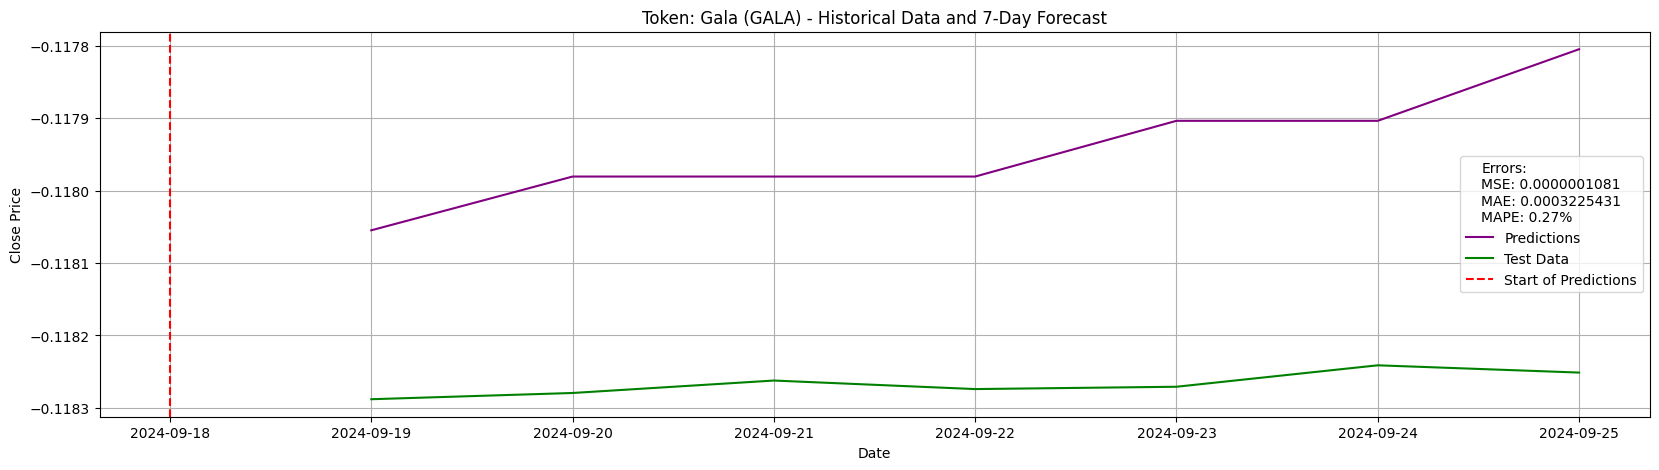

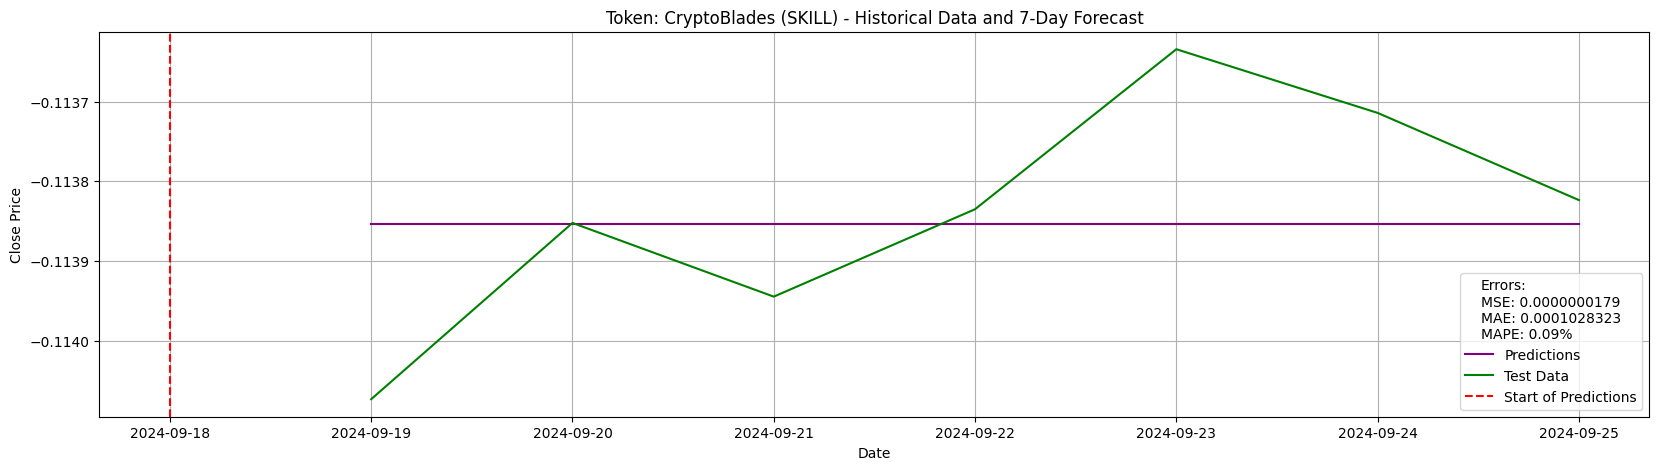

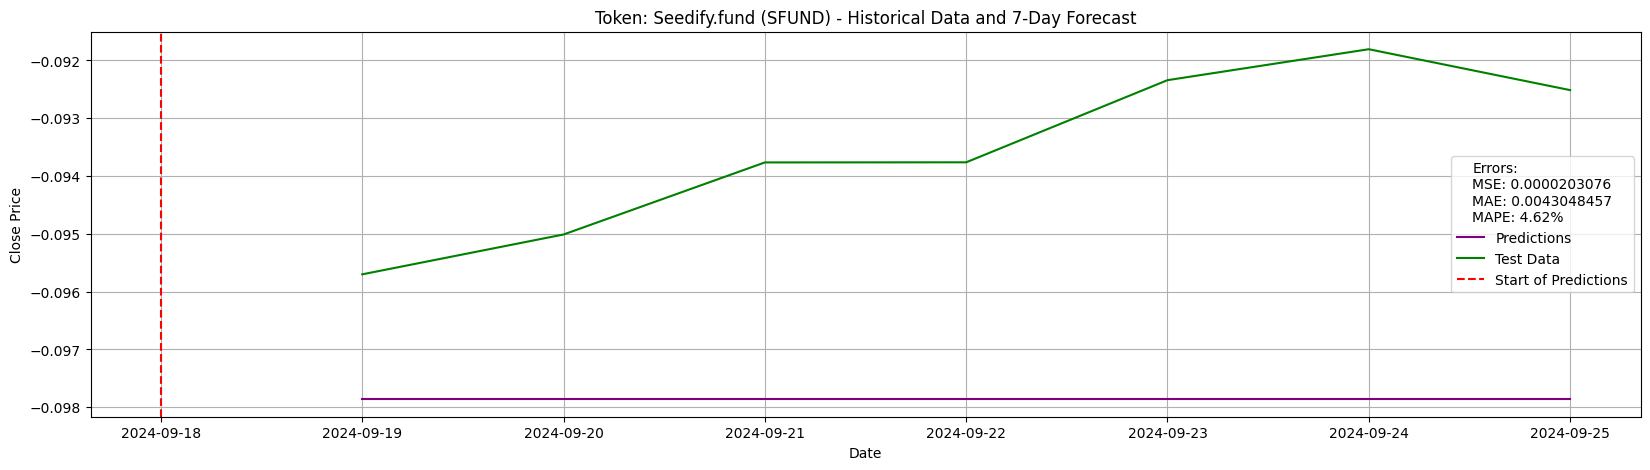

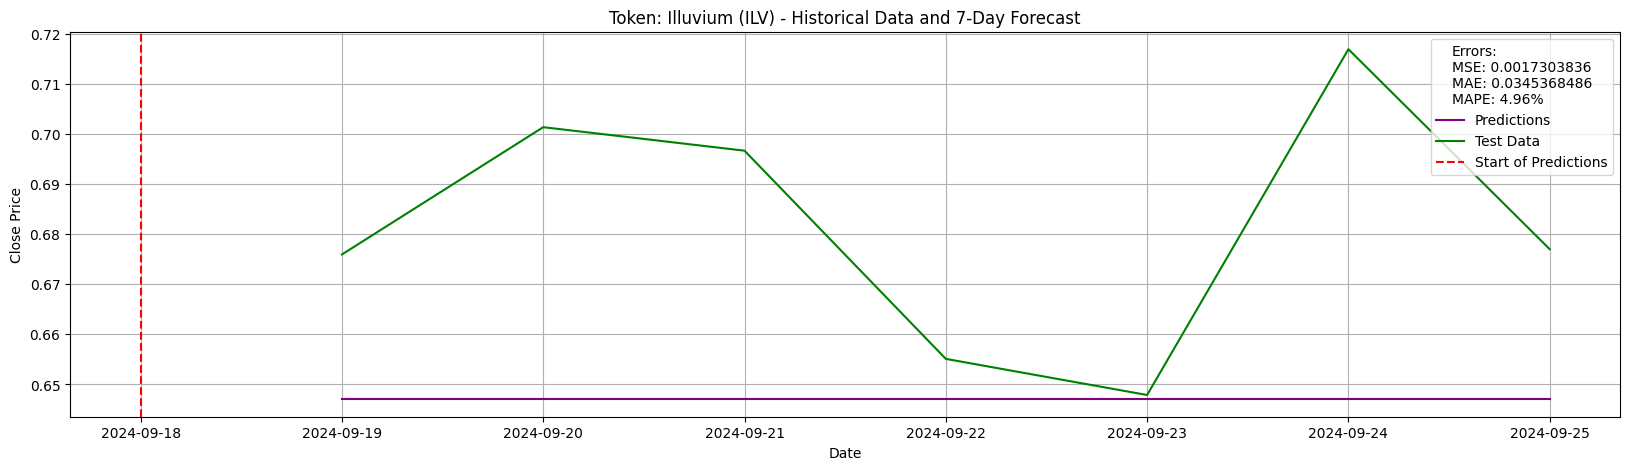

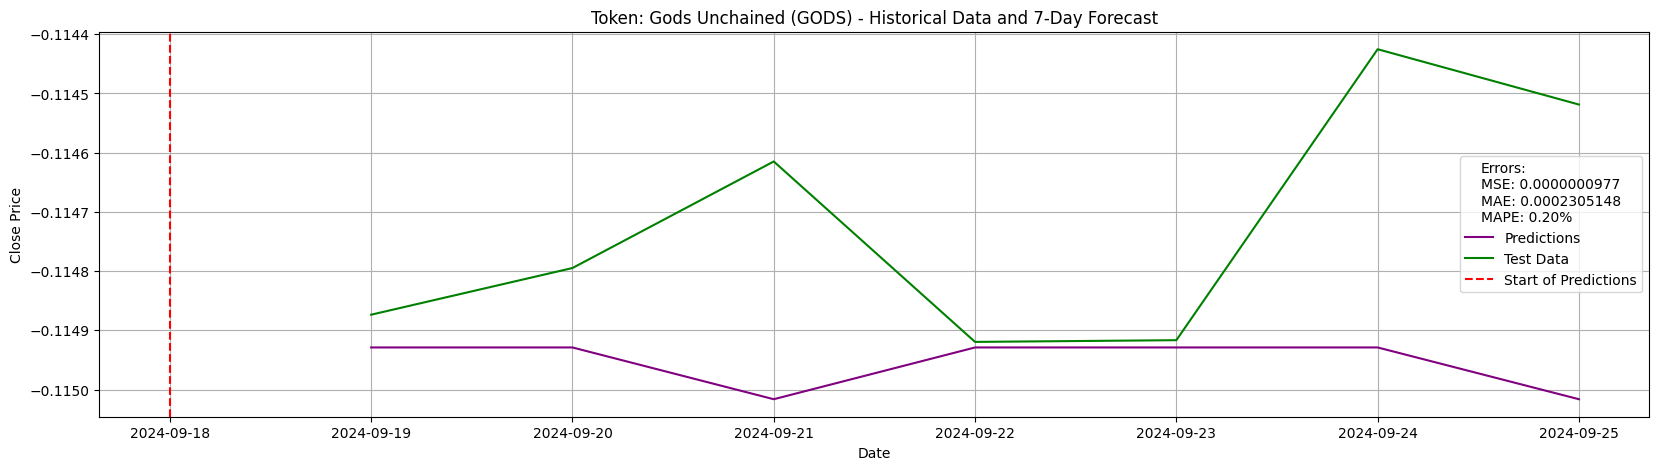

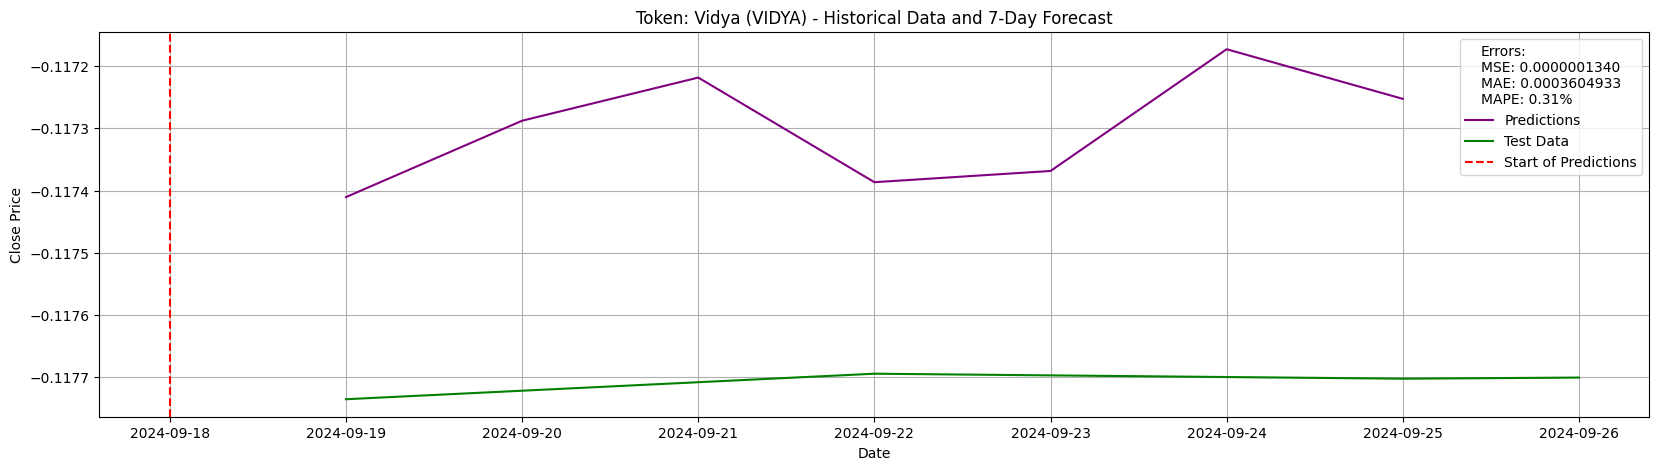

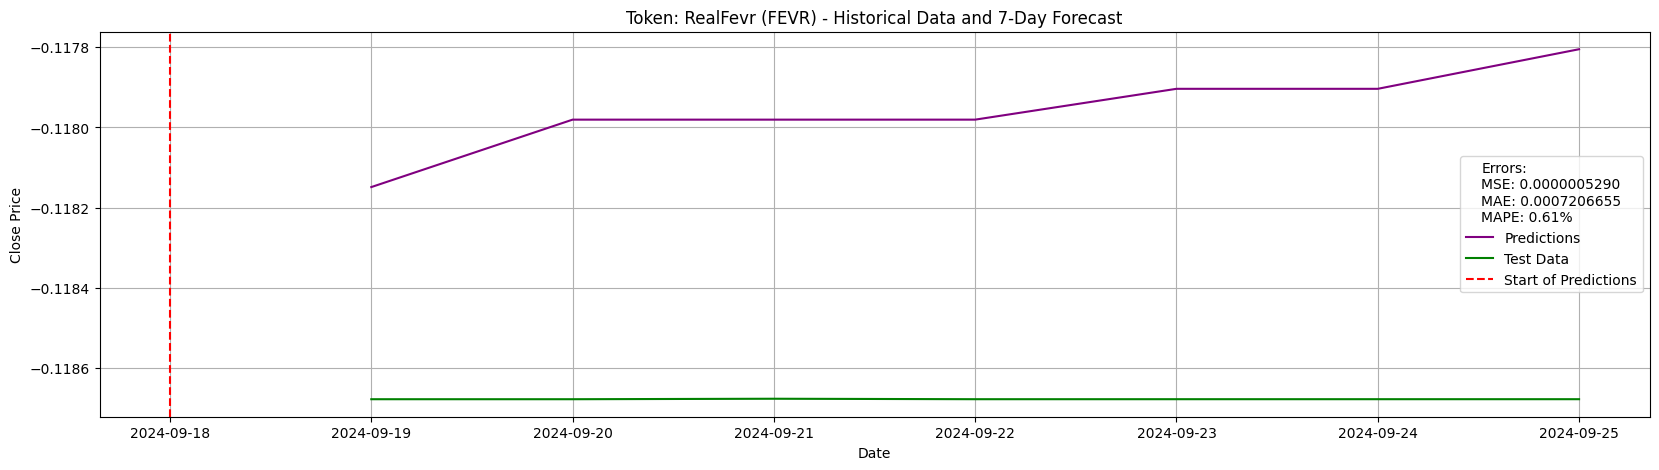

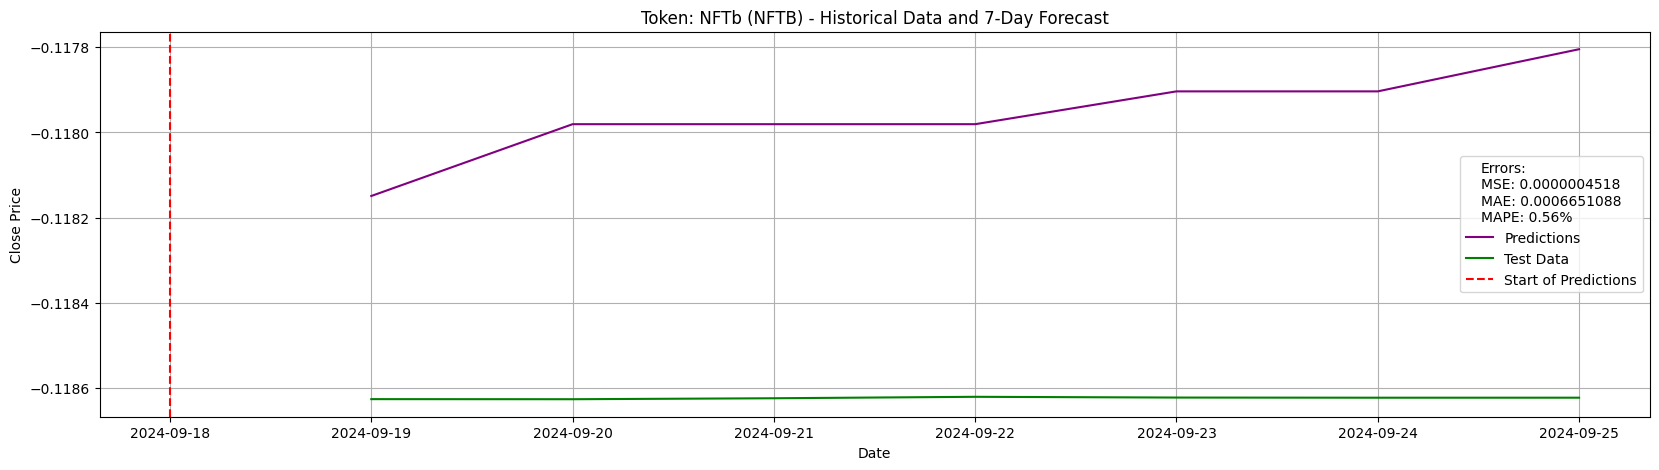

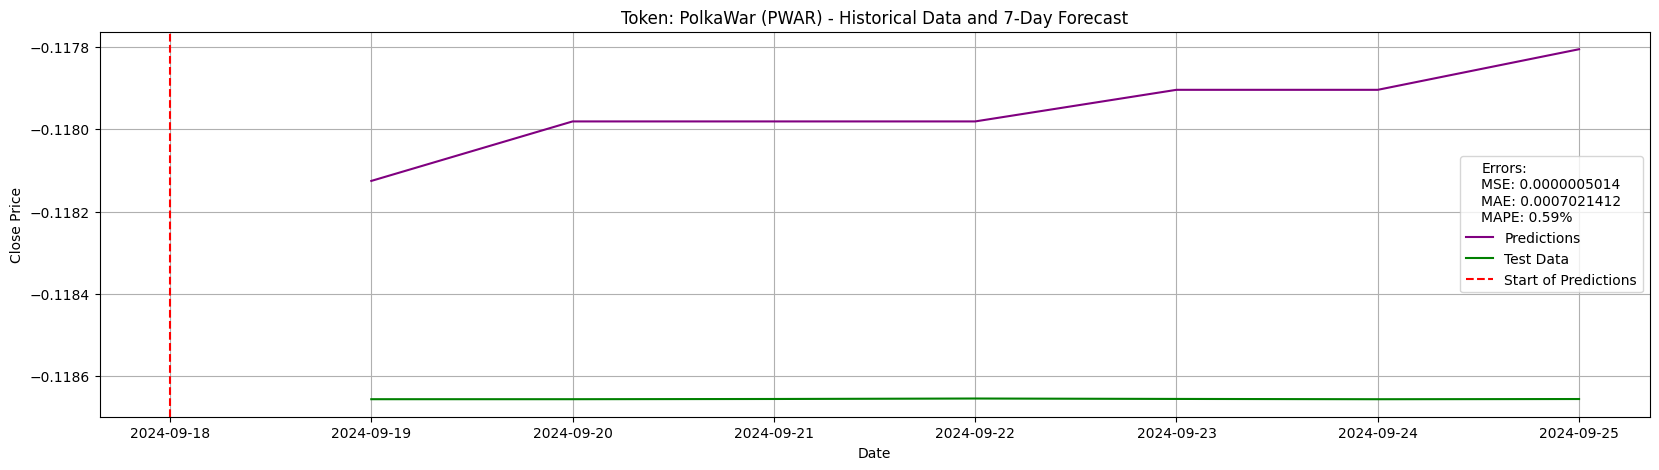

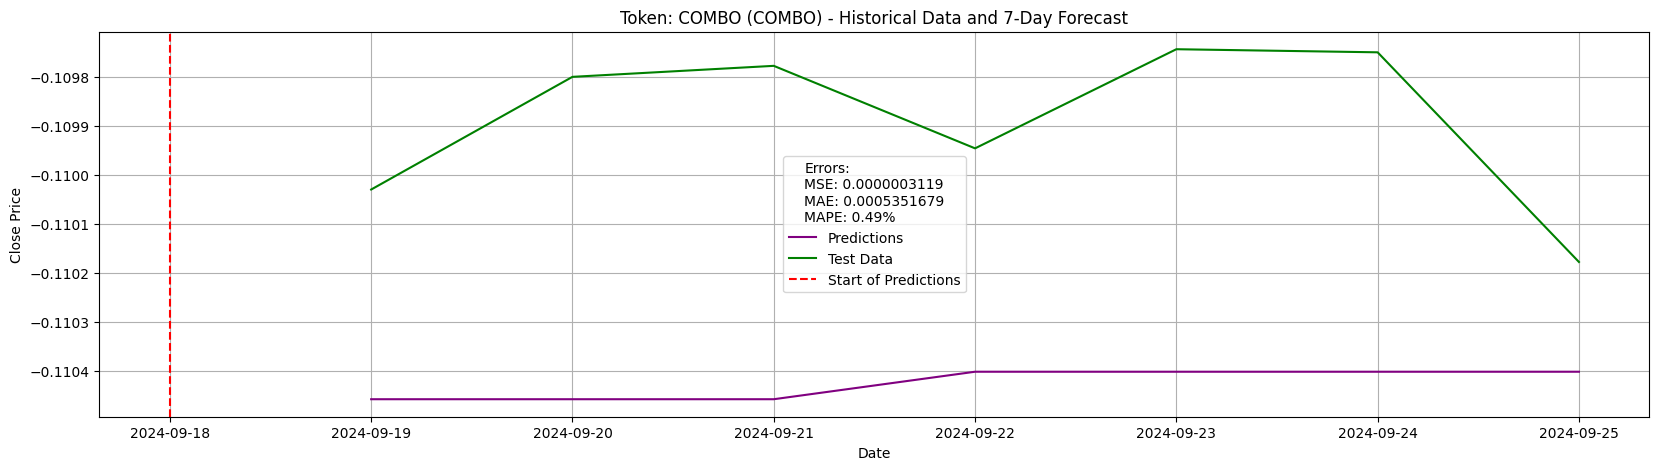

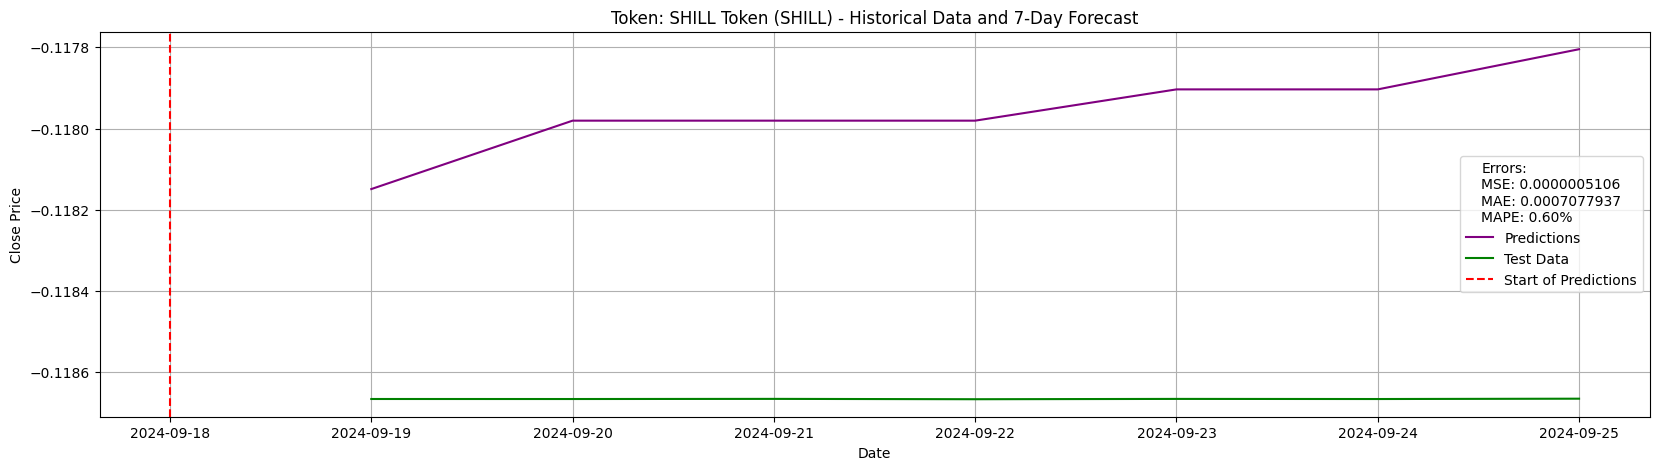

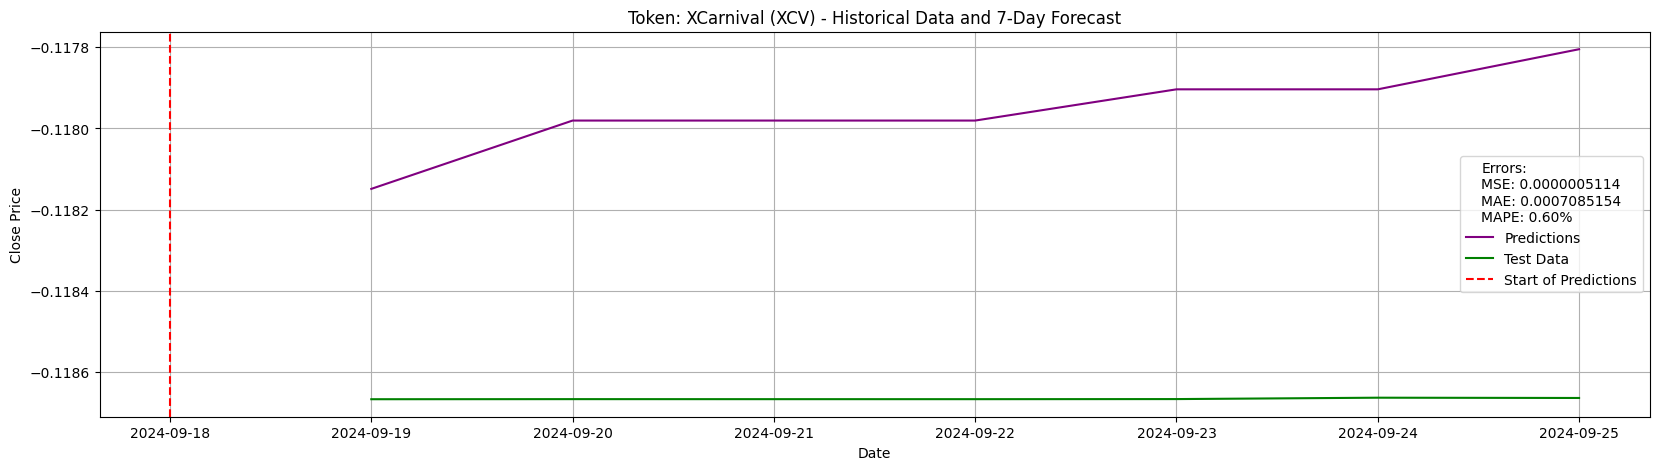

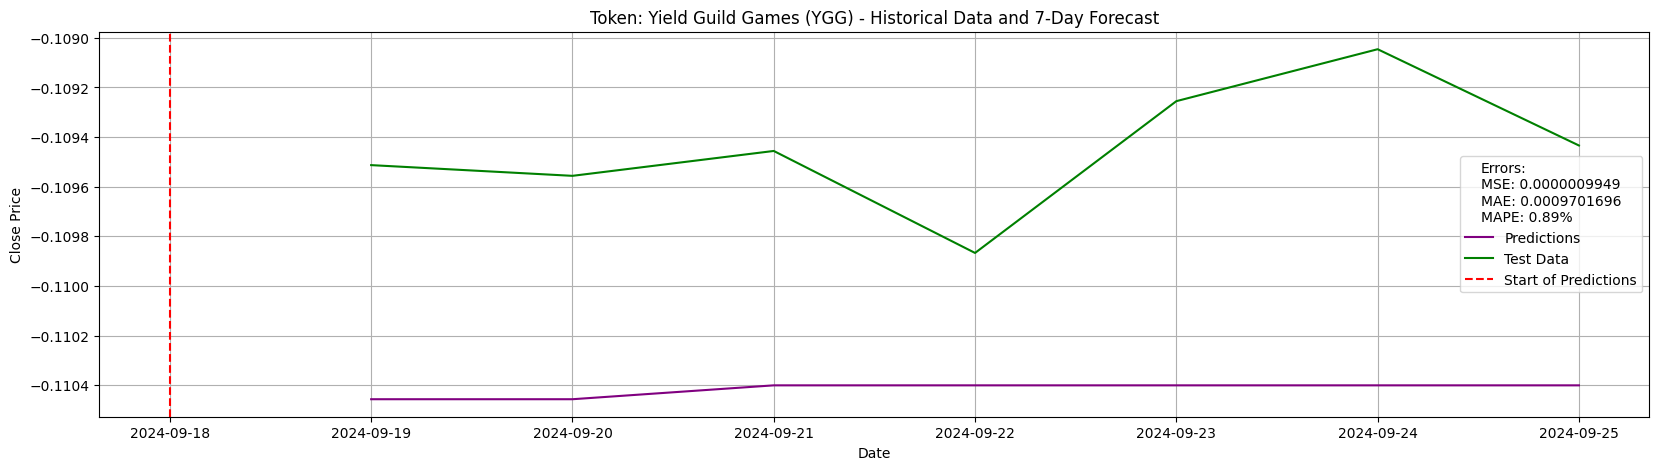

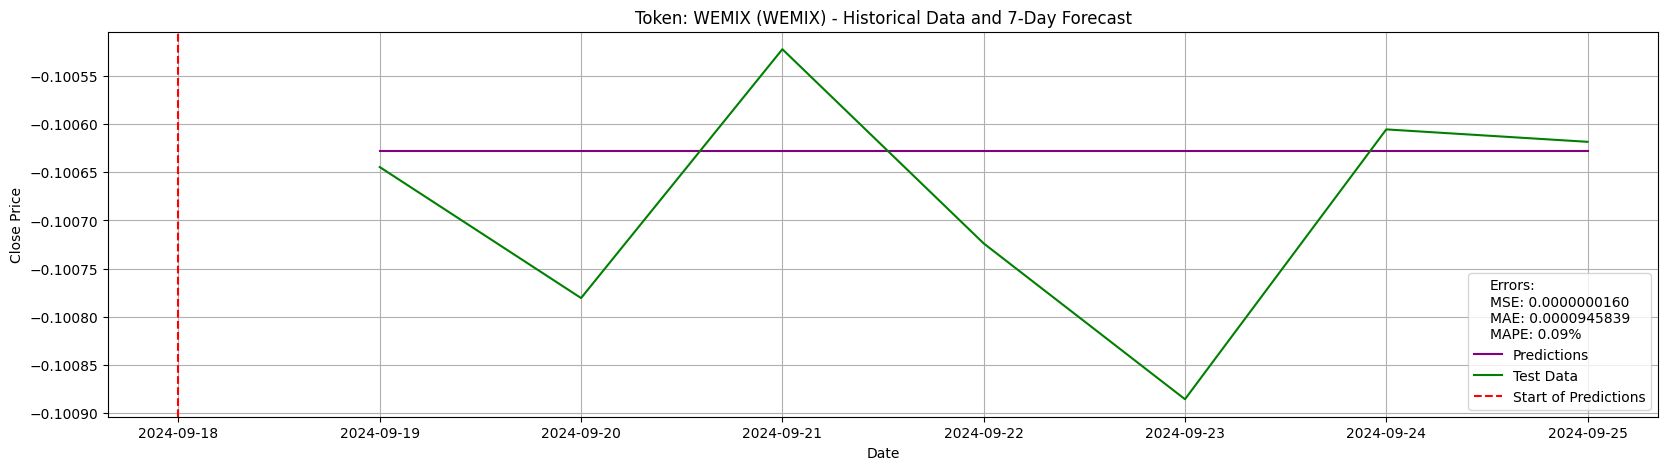

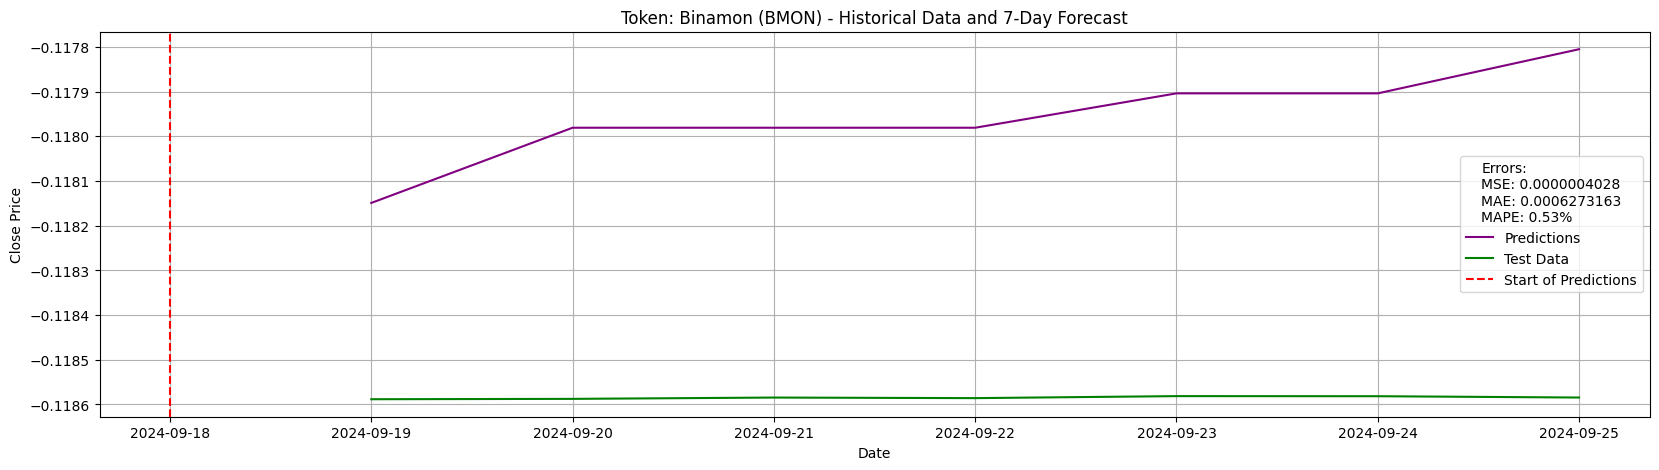

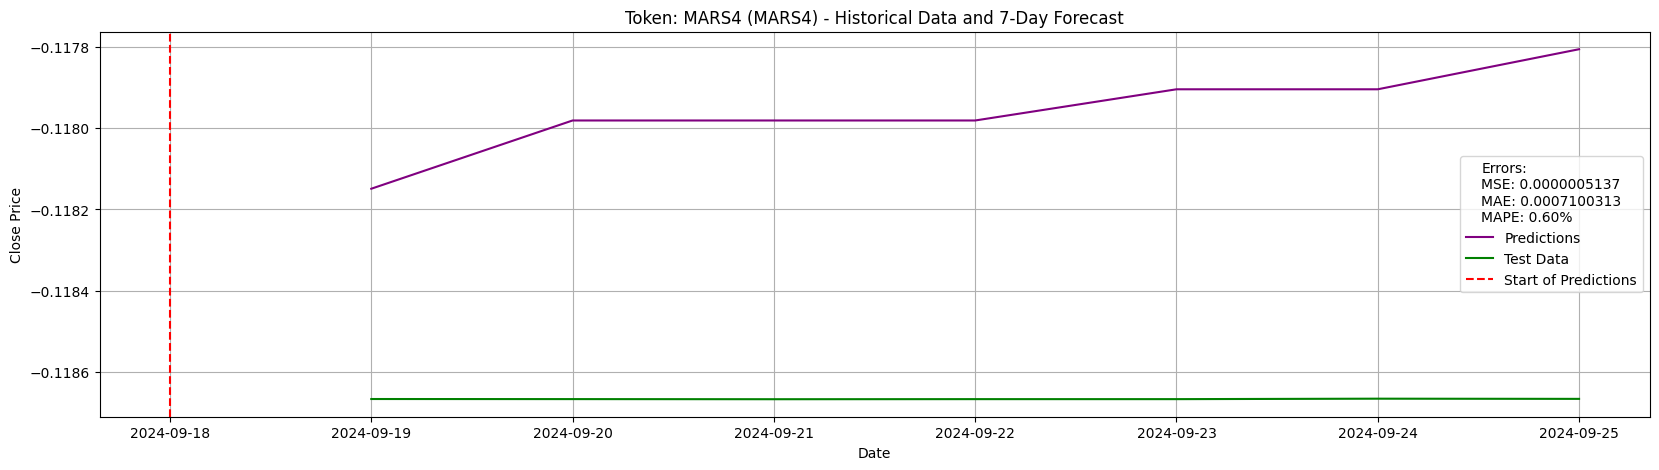

In [20]:
error_dict = u.plot_predictions(train_data=train_data, predictions_x_days=predictions, test_data=test_data, max_coins=0, last_data_points=0)